# 0. Setup

In [ ]:
# reload all modules every time before executing
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from pathlib import Path
import sys, types

import numpy as np

In [ ]:
# Patch for pickle compatibility
if 'recover_core_lib' not in sys.modules:
    print('adding `recover_core_lib` to sys')
    fake = types.ModuleType('recover_core_lib')
    fake.compute_CAM2_translations_v3_cupy = lambda *a, **k: None
    sys.modules['recover_core_lib'] = fake

adding `recover_core_lib` to sys


In [ ]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [ ]:
# this automatically displays all plots, even if we don't have plt.show()
# this also makes all plots interactive
%matplotlib widget

# 1. Load Data

In [ ]:
from collections import defaultdict

In [ ]:
BASE_DIR = Path('../data/experiment_01/')
exp_dirs = sorted([d for d in BASE_DIR.iterdir() if d.is_dir()])
print(f'Found {len(exp_dirs)} experiment directories')
exp_dirs

Found 8 experiment directories


[PosixPath('../data/experiment_01/cube_pos1_29_12_Time_19_16_40'),
 PosixPath('../data/experiment_01/cube_pos2_29_12_Time_19_03_39'),
 PosixPath('../data/experiment_01/cube_pos2_29_12_Time_19_13_50'),
 PosixPath('../data/experiment_01/cube_pos3_29_12_Time_19_27_21'),
 PosixPath('../data/experiment_01/cube_pos3_29_12_Time_19_29_43'),
 PosixPath('../data/experiment_01/cube_pos4_29_12_Time_19_24_21'),
 PosixPath('../data/experiment_01/cube_pos5_29_12_Time_19_22_12'),
 PosixPath('../data/experiment_01/cube_pos6_29_12_Time_19_20_07')]

In [ ]:
def load_data(exp_dirs) -> dict:
    """Load recovery and metadata from an experiment directory."""

    duplicate_idx_map = defaultdict(int)
    data = {}

    for exp_dir in exp_dirs:
        recovery = np.load(exp_dir / 'RECOVERY.npz', allow_pickle=True)
        fs = recovery['run_opt'].item()['cam_params']['camera_FPS'] # use frames-per-second as sampling-frequency

        object = str(exp_dir).split('/')[-1].split('_')[0]
        position = int(str(exp_dir).split('/')[-1].split('_')[1][3:])

        key = (object, position)
        duplicate_idx_map[key] += 1
        duplicate_idx = duplicate_idx_map[key]

        name = f'{object}-pos{position}-{duplicate_idx:02}'
        shifts_raw = recovery['all_shifts']

        time = np.arange(shifts_raw.shape[1]) / fs

        d = {
            'object': object,
            'position': position,
            'duplicate_idx': duplicate_idx,
            'fs': fs,
            'path': exp_dir,
            'shifts_raw': shifts_raw,
            'time': time,
        }
        data[name] = d
    return data

In [ ]:
data = load_data(exp_dirs)
len(data)

8

In [ ]:
list(data.keys())

['cube-pos1-01',
 'cube-pos2-01',
 'cube-pos2-02',
 'cube-pos3-01',
 'cube-pos3-02',
 'cube-pos4-01',
 'cube-pos5-01',
 'cube-pos6-01']

In [ ]:
list(list(data.values())[0].keys())

['object', 'position', 'duplicate_idx', 'fs', 'path', 'shifts_raw', 'time']

# 2. Compute FFT

In [ ]:
def shifts_to_fft(shifts, fs, min_freq=None, max_freq=None):
    # compute fft values and frequencies
    fft_val = np.fft.rfft(shifts, axis=1)
    n_samples = shifts.shape[1]
    freq = np.fft.rfftfreq(n_samples, d=1.0/fs)

    # crop the frequency
    if min_freq is not None and max_freq is not None:
        mask = (freq >= min_freq) & (freq <= max_freq)
        fft_val, freq = fft_val[:, mask, :], freq[mask]
    return fft_val, freq

In [ ]:
def fft_magnitude(fft_vals, return_std=False):
    """Compute fft magnitude and average it over all the lasers and x,y coordinates"""
    if len(fft_vals.shape) == 3: # (n_lasers, n_freqs, n_coords)
        fft_mag_mean = np.abs(fft_vals).mean(axis=(0,2))
        return (fft_mag_mean, np.abs(fft_vals).std(axis=(0,2))) if return_std else fft_mag_mean
    elif len(fft_vals.shape) == 2: # (n_lasers, n_coords) we already chose a specific frequency
        fft_mag_mean = np.abs(fft_vals).mean()
        return (fft_mag_mean, np.abs(fft_vals).std()) if return_std else fft_mag_mean
    else:
        raise ValueError()

In [ ]:
def fft_angle(fft_vals, return_std=False):
    """Compute fft angle and average it over all the lasers and x,y coordinates"""
    if len(fft_vals.shape) == 3: # (n_lasers, n_freqs, n_coords)
        fft_mag_mean = np.angle(fft_vals).mean(axis=(0,2))
        return (fft_mag_mean, np.angle(fft_vals).std(axis=(0,2))) if return_std else fft_mag_mean
    elif len(fft_vals.shape) == 2: # (n_lasers, n_coords) we already chose a specific frequency
        fft_mag_mean = np.angle(fft_vals).mean()
        return (fft_mag_mean, np.angle(fft_vals).std()) if return_std else fft_mag_mean
    else:
        raise ValueError()

# 3. Clean Data

In [ ]:
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfiltfilt

In [ ]:
def bandpass_filter(shifts, fs, lowcut=50, highcut=None, order=5):
    """Removes frequencies outside of [lowcut, highcut].
    sosfiltfilt applies the filter forward and backward, giving zero phase distortion."""
    if highcut is None: highcut = fs / 2 - 10  # Slightly below Nyquist frequency

    n_lasers, _, n_coords = shifts.shape
    filtered_shifts = np.empty_like(shifts)

    for i in range(n_lasers):
        for j in range(n_coords):
            sos = butter(order, [lowcut, highcut], fs=fs, btype='band', output='sos')
            filtered_shifts[i, :, j] = sosfiltfilt(sos, shifts[i, :, j])
    return filtered_shifts

In [ ]:
def hann_window(shifts):
    window = np.hanning(shifts.shape[1])
    return shifts * window[:, np.newaxis]

In [ ]:
def plot_clean_data(shifts, fs, xlim=(None, None)):
    # fft for raw signal
    fft_vals, freq = shifts_to_fft(shifts, fs)

    # fft for bandpass filter
    bp_shifts = bandpass_filter(shifts, fs)
    bp_fft_vals, bp_freq = shifts_to_fft(bp_shifts, fs)

    # fft for bandpass filter + hann window
    wd_shifts = hann_window(bp_shifts)
    wd_fft_vals, wd_freq = shifts_to_fft(wd_shifts, fs)

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(freq, fft_magnitude(fft_vals), label='raw')
    ax.plot(bp_freq, fft_magnitude(bp_fft_vals), label='bandpass filter')
    ax.plot(wd_freq, fft_magnitude(wd_fft_vals), label='bandpass filter + hann window')
    ax.set(xlim=xlim, ylim=(0, 200), xlabel='Frequency (Hz)', ylabel='Mean FFT Magnitude')
    ax.legend()
    fig.suptitle('Clean the Data')
    return fig

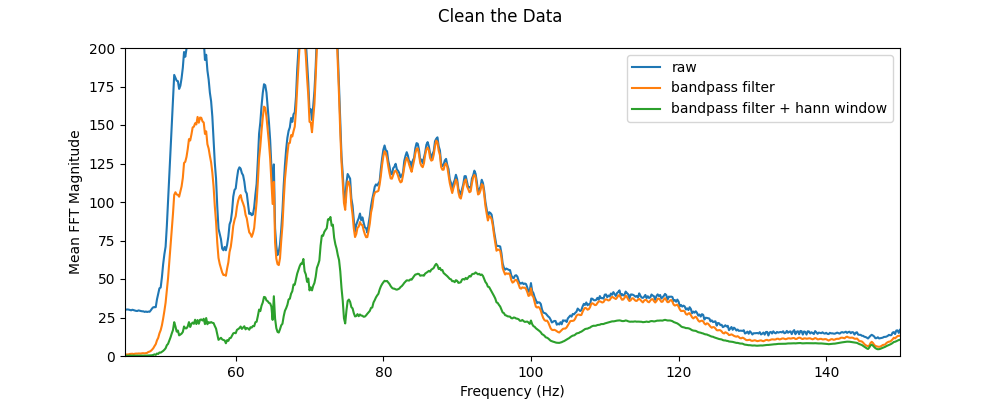

In [ ]:
d = list(data.values())[0]
fig = plot_clean_data(d['shifts_raw'], d['fs'], xlim=(45, 150))

The fft vals looks much cleaner with bandpass filter + hann window. Let's define a function to clean the shifts and compute the fft on this cleaned data.

In [ ]:
def clean_shifts(shifts, fs):
    shifts_bp = bandpass_filter(shifts, fs)
    shifts_wd = hann_window(shifts_bp)
    return shifts_wd

Now let's take a look at all the frequencies.

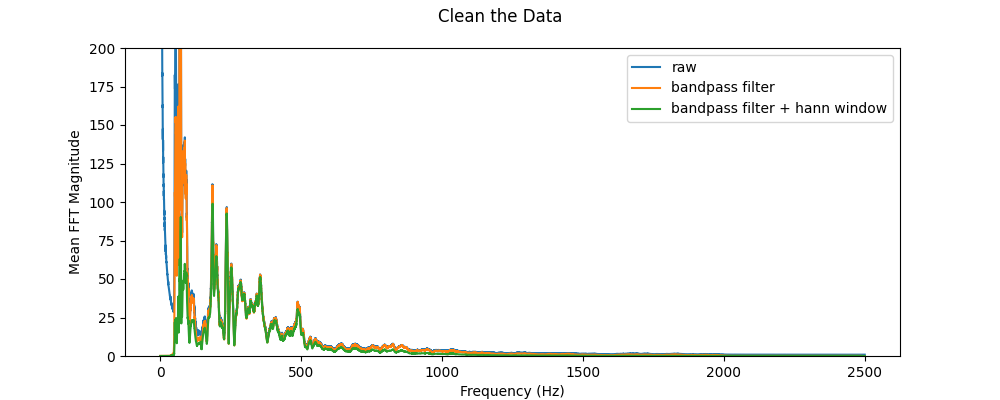

In [ ]:
fig = plot_clean_data(d['shifts_raw'], d['fs'])

Notice that there isn't really any signal after 1000 hz so we'll crop it at 1100 hz.

In [ ]:
MIN_FREQ, MAX_FREQ = 50, 1_000

In [ ]:
for name, d in data.items():
    d['shifts'] = clean_shifts(d['shifts_raw'], d['fs'])
    fft_val, freq = shifts_to_fft(d['shifts'], d['fs'], MIN_FREQ, MAX_FREQ)
    d['fft_vals'], d['freqs'] = fft_val, freq

In [ ]:
list(d.keys())

['object',
 'position',
 'duplicate_idx',
 'fs',
 'path',
 'shifts_raw',
 'time',
 'shifts',
 'fft_vals',
 'freqs']

# 4. Compute Modes

In [ ]:
from scipy.signal import find_peaks
from matplotlib.widgets import RangeSlider

In [ ]:
def find_modes(freqs, fft_vals, n_modes=5, min_distance=100):
    """Find the top n_modes frequency peaks from mean FFT magnitude (averaged over lasers + x/y coordinate).

    Returns list of (frequency, magnitude, time) tuples sorted by frequency.
    Time is estimated assuming a log chirp from 50-2000 Hz over the recording duration.
    """

    mean_mag = fft_magnitude(fft_vals)
    peaks, _ = find_peaks(mean_mag, distance=min_distance)
    peak_mags = mean_mag[peaks]

    # Sort by magnitude and take top n_modes
    top_indices = np.argsort(peak_mags)[-n_modes:][::-1]
    mode_freqs_idx = np.array(sorted(peaks[top_indices]))

    mode_freqs = freqs[mode_freqs_idx]
    mode_fft_vals = fft_vals[:, mode_freqs_idx, :]
    return mode_freqs_idx, mode_freqs, mode_fft_vals

In [ ]:
def plot_fft_with_modes(data, mode_freq_key='_mode_freqs', mode_fft_vals_idx='_mode_fft_vals'):
    fig, axes = plt.subplots(2, 3, figsize=(15, 5))
    axes = axes.flatten()

    min_freq = min([min(d.get(mode_freq_key, d['freqs'].min())) for d in data.values()])
    max_freq = max([max(d.get(mode_freq_key, d['freqs'].max())) for d in data.values()])

    for d in data.values():
        # skip duplicates
        if d['duplicate_idx'] != 1: continue
        ax_idx = d['position'] - 1
        ax = axes[ax_idx]
        freqs, fft_vals = d['freqs'], d['fft_vals']

        mean, std = fft_magnitude(fft_vals, return_std=True)
        ax.plot(freq, mean, lw=0.8)
        ax.fill_between(freq, mean - std, mean + std, alpha=0.3)

        if mode_freq_key in d:
            for mode_freq, mode_fft_val in zip(d[mode_freq_key], d['_mode_fft_vals']):
                mode_fft_mag = fft_magnitude(mode_fft_val)
                ax.axvline(mode_freq, color='red', linestyle='--', alpha=0.7, lw=1)
                ax.scatter([mode_freq], [mode_fft_mag], color='red', s=50, zorder=5)
                ax.annotate(f'{mode_freq:.0f} Hz', (mode_freq, mode_fft_mag), textcoords='offset points',
                           xytext=(5, 5), fontsize=8, color='red')

        ax.set(title=f'Position {d['position']}', xlim=(min_freq*0.9, max_freq*1.1))
        ax.grid(True, alpha=0.3)
        n_modes = len(d[mode_freq_key])

    # 1. Set your labels as you did before
    for ax in axes[-3:]:
        ax.set_xlabel('Frequency (Hz)')

    for ax in axes[::3]:
        ax.set_ylabel('Magnitude')

    # 2. Clean up the ticks based on the presence of those labels
    for ax in axes.flatten():
        ax.tick_params(axis='x', labelbottom=bool(ax.get_xlabel()), bottom=bool(ax.get_xlabel()))
        ax.tick_params(axis='y', labelleft=bool(ax.get_ylabel()), left=bool(ax.get_ylabel()))


    plt.tight_layout(rect=[0, 0, 1, 0.95])
    title_suffix = f"\n{d[mode_freq_key]}" if 'cannonical' in mode_freq_key else ""
    fig.suptitle(f'FFT Magnitude {n_modes} modes'+title_suffix, fontsize=12)

    # Add range slider for frequency zoom
    ax_slider = fig.add_axes([0.15, 0.02, 0.7, 0.03])
    slider = RangeSlider(ax_slider, 'Freq (Hz)', freq.min(), freq.max(), valinit=(min_freq*0.9, max_freq*1.1))

    def update(val):
        freq_min, freq_max = val
        for ax in axes: ax.set_xlim(freq_min, freq_max)
        fig.canvas.draw_idle()
    slider.on_changed(update)

    # Keep a reference to the slider to prevent garbage collection
    fig._slider = slider
    return fig

In [28]:
def plot_mode_frequency_overlap(data):
    """Bubble plot showing mode frequencies across positions.

    X-axis: frequency (Hz)
    Y-axis: position
    Marker size: proportional to mean FFT magnitude at that mode
    """
    fig, ax = plt.subplots(figsize=(14, 6))

    positions = []
    frequencies = []
    magnitudes = []

    for name, d in data.items():
        if d['duplicate_idx'] != 1:
            continue

        pos = d['position']
        for mode_freq, mode_fft_val in zip(d['_mode_freqs'], d['_mode_fft_vals']):
            mag = fft_magnitude(mode_fft_val).item()
            positions.append(pos)
            frequencies.append(mode_freq)
            magnitudes.append(mag)

    n_modes = len(d['_mode_freqs'])
    positions = np.array(positions)
    frequencies = np.array(frequencies)
    magnitudes = np.array(magnitudes)

    # Draw horizontal lines for each position
    unique_positions = sorted(set(positions))
    for pos in unique_positions:
        ax.axhline(pos, color='gray', linestyle='-', alpha=0.3, linewidth=1)

    # Normalize magnitudes for marker sizes (scale to reasonable range)
    size_scale = 1_200
    # sizes = (magnitudes / magnitudes.max()) * size_scale
    sizes = np.power(magnitudes, 5) / np.power(magnitudes, 5).sum() * 10_000

    # Color by even/odd position
    colors = ['tab:blue' if pos % 2 == 0 else 'tab:orange' for pos in positions]

    scatter = ax.scatter(frequencies, positions, s=sizes, alpha=0.6,
                         c=colors, edgecolor='black', linewidth=0.5)

    # Add magnitude labels on each bubble
    for freq, pos, mag in zip(frequencies, positions, magnitudes):
        ax.annotate(f'{freq:.0f}', (freq, pos), ha='center', va='center',
                    fontsize=7, fontweight='bold', color='black')

    ax.set_xlabel('Frequency (Hz)', fontsize=11)
    ax.set_ylabel('Position', fontsize=11)
    ax.set_yticks(unique_positions)
    ax.grid(True, alpha=0.3, axis='x')

    # Add size legend
    legend_sizes = [0.25, 0.5, 1.0]
    legend_labels = [f'{int(s * magnitudes.max()):.0f}' for s in legend_sizes]
    for s, label in zip(legend_sizes, legend_labels):
        ax.scatter([], [], s=s * size_scale, c='gray', alpha=0.6, edgecolor='black')

    # Add color legend for even/odd
    ax.scatter([], [], s=100, c='tab:blue', alpha=0.6, edgecolor='black', label='Even positions')
    ax.scatter([], [], s=100, c='tab:orange', alpha=0.6, edgecolor='black', label='Odd positions')
    ax.legend(title='Position Parity', loc='upper right', frameon=True)

    fig.suptitle(f'{n_modes} Mode Frequencies Across Positions\n(marker size ~ mean FFT magnitude)',
                 fontsize=12, fontweight='bold')
    plt.tight_layout()
    return fig

Let's compute the mode for each position by looking at the peaks of every FFT magnitude. Note: here each position has a different mode. We will "cannonacalize" the modes later.

Play around with the `n_samples`, `min_distance` parameters until they look right by inspecting the two plots.

In [29]:
# play around with these parameters until they look right using the plot_fft_by_position function
n_modes = 5 # 10
min_distance = 100

for name, d in data.items():
    mode_freqs_idx, mode_freqs, mode_fft_vals = find_modes(d['freqs'], d['fft_vals'], n_modes, min_distance)
    d['_mode_freqs_idx'], d['_mode_freqs'], d['_mode_fft_vals'] = mode_freqs_idx, mode_freqs, mode_fft_vals

In [30]:
d['_mode_freqs']

array([ 73.        ,  92.66666667, 185.83333333, 236.        ,
       355.16666667])

In [31]:
d['_mode_fft_vals'].shape

(100, 5, 2)

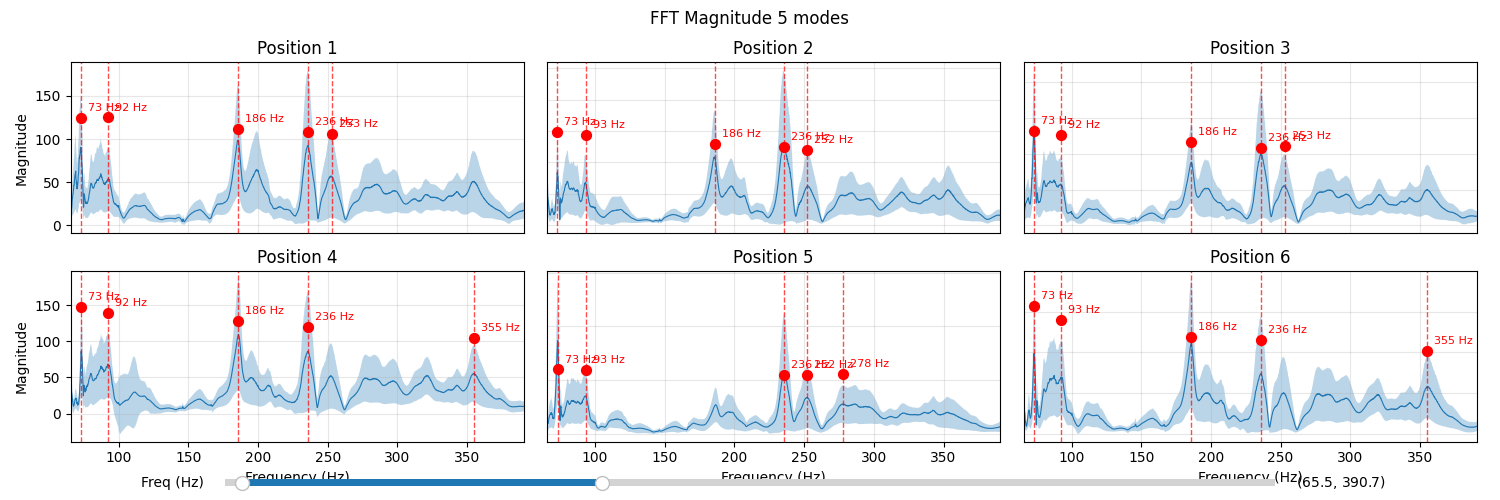

In [32]:
fig = plot_fft_with_modes(data)

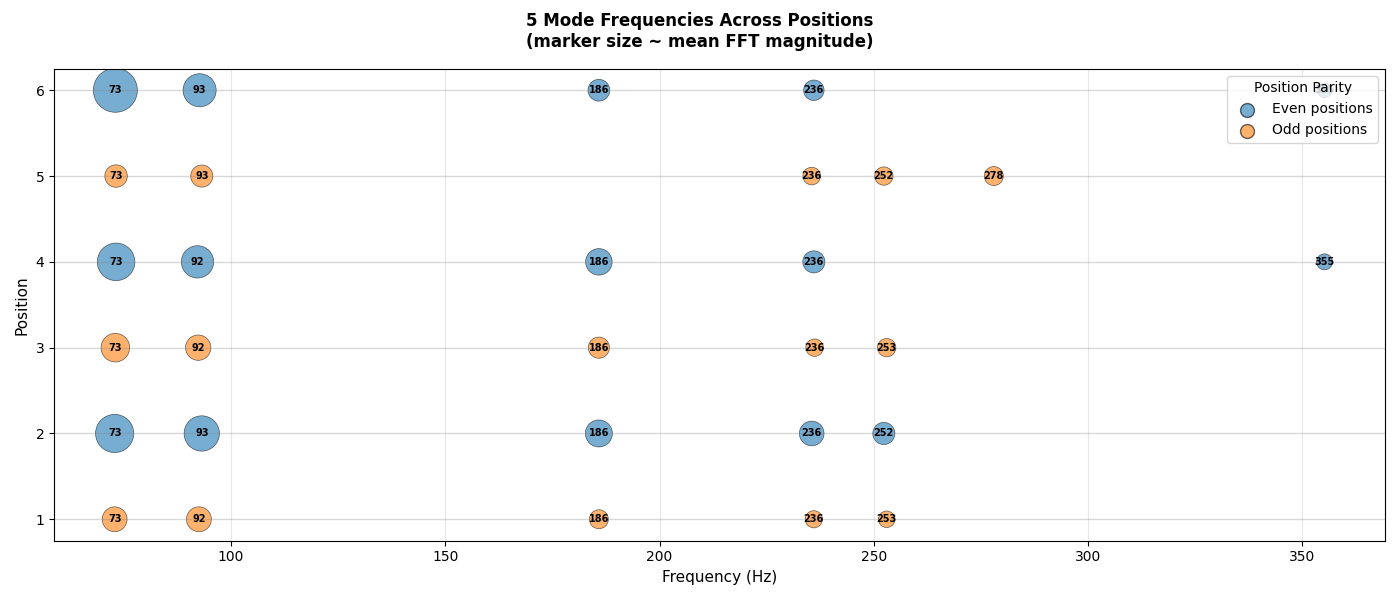

In [33]:
fig = plot_mode_frequency_overlap(data)
plt.show()

Based on our graphs, let's define our canonical modes as the modes from position 3. The canonical modes do not have a '_' in their key names.

In [34]:
list(data['cube-pos3-01'].keys())

['object',
 'position',
 'duplicate_idx',
 'fs',
 'path',
 'shifts_raw',
 'time',
 'shifts',
 'fft_vals',
 'freqs',
 '_mode_freqs_idx',
 '_mode_freqs',
 '_mode_fft_vals']

In [35]:
# Use mode frequencies from position 3 as the canonical reference
canonical_mode_freqs = data['cube-pos3-01']['_mode_freqs']

for name, d in data.items():
    # Store the canonical frequencies
    d['mode_freqs'] = canonical_mode_freqs

    # Find the closest frequency index in THIS position's frequency array for each canonical mode frequency
    freq_indices = []
    for target_freq in canonical_mode_freqs:
        idx = np.argmin(np.abs(d['freqs'] - target_freq))
        freq_indices.append(idx)

    d['mode_freqs_idx'] = np.array(freq_indices)

    # Extract FFT values at those indices from THIS position's fft_vals
    d['mode_fft_vals'] = d['fft_vals'][:, freq_indices, :]

# 5. Sync Phases

In [67]:
def sync_phases(fft_vals, laser_idx=0, xy_idx=0, eps=1e-12):
    fft_vals_synced = fft_vals.copy()             # copy
    ref = fft_vals[laser_idx, :, xy_idx]          # shape (freq,)
    phase = np.conj(ref) / (np.abs(ref)**2 + eps) # unit complex + divide by magnitude
    fft_vals_synced *= phase[None, :, None]       # broadcast over lasers and xy
    assert np.allclose(1, np.real(fft_vals_synced[laser_idx, :, xy_idx])) # check we have magnitude 1
    return fft_vals_synced # (n_lasers, n_freqs, 2)

In [68]:
def get_gradients(fft_vals, n_lasers):
    """Extract real-valued gradients from complex FFT values, reshaped to (n_modes, 2, grid, grid).

    Args:
        fft_vals: shape (n_lasers^2, n_modes, 2) - complex FFT values
        n_lasers: grid dimension (e.g., 10 for 10x10 grid)

    Returns:
        gradients: shape (n_modes, 2, n_lasers, n_lasers) - real-valued gradients
                   Access as gradients[mode_idx, 0] for dx, gradients[mode_idx, 1] for dy
    """
    fft_vals = np.real(fft_vals)  # shape: (100, n_modes, 2)
    # Reshape: (100, n_modes, 2) -> (10, 10, n_modes, 2) -> (n_modes, 2, 10, 10)
    gradients = fft_vals.reshape(n_lasers, n_lasers, -1, 2)
    gradients = gradients.transpose(2, 3, 0, 1)  # (n_modes, 2, n_lasers, n_lasers)
    return gradients

In [69]:
for name, d in data.items():
    d['synced_fft_vals'] = sync_phases(d['fft_vals'])
    d['synced_mode_fft_vals'] = sync_phases(d['mode_fft_vals'])
    n_lasers = int(np.sqrt(d['shifts'].shape[0]))
    d['synced_fft_gradients'] = get_gradients(d['synced_fft_vals'], n_lasers)  # shape: (n_freqs, 2, 10, 10)
    d['synced_mode_fft_gradients'] = get_gradients(d['synced_mode_fft_vals'], n_lasers)  # shape: (n_modes, 2, 10, 10)

In [70]:
d['synced_mode_fft_vals'].shape

(100, 5, 2)

Visualize the mode shapes as quiver plots. Each subplot shows one mode, and you can toggle different box positions on/off to compare their vibration patterns.

/var/folders/f6/vzqh7ynx4n3ft_sx36yv3gbm0000gn/T/ipykernel_86841/3600879795.py:158: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


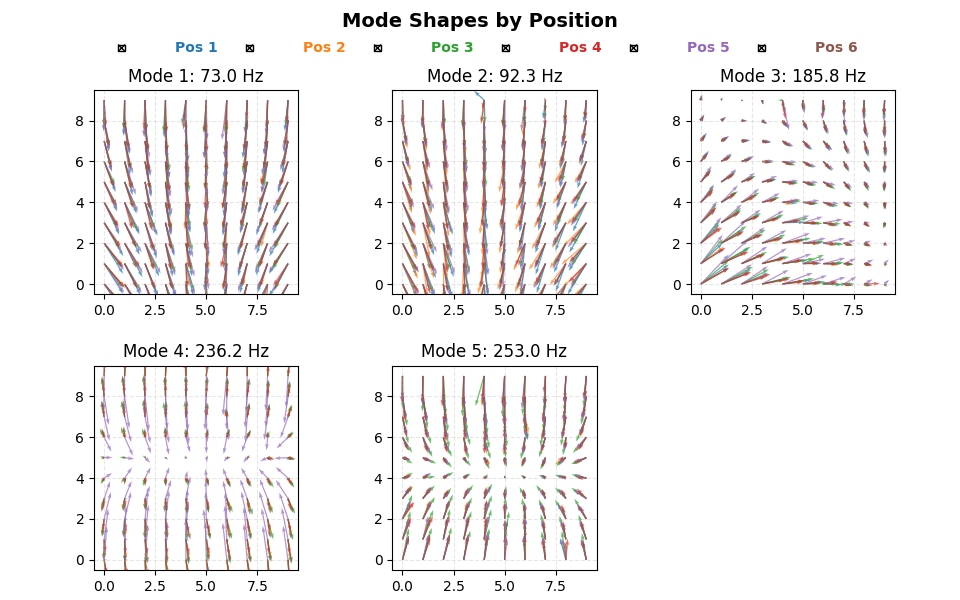

In [77]:
from matplotlib.widgets import CheckButtons

# Color palette for positions
POSITION_COLORS = {
    1: '#1f77b4',  # blue
    2: '#ff7f0e',  # orange
    3: '#2ca02c',  # green
    4: '#d62728',  # red
    5: '#9467bd',  # purple
    6: '#8c564b',  # brown
}


def plot_mode_quivers(data, n_cols=3, scale_per_mode=False):
    """
    Interactive quiver plot showing mode shapes for all positions.

    Each subplot = one mode. Toggle positions on/off with checkboxes.
    Quiver arrows show (dx, dy) shifts at each laser point for that mode.

    Args:
        data: dict of experiment data
        n_cols: number of columns in subplot grid
        scale_per_mode: if True, each mode is scaled independently for better visibility
    """
    # Get positions (skip duplicates)
    positions = sorted(set(d['position'] for d in data.values() if d['duplicate_idx'] == 1))

    # Get dimensions from first entry
    d0 = next(d for d in data.values() if d['duplicate_idx'] == 1)
    n_modes = len(d0['mode_freqs'])
    n_lasers = int(np.sqrt(d0['shifts'].shape[0]))
    mode_freqs = d0['mode_freqs']

    # Grid coordinates
    X, Y = np.meshgrid(np.arange(n_lasers), np.arange(n_lasers))

    # Setup figure with space for horizontal checkbox bar at top
    n_rows = int(np.ceil(n_modes / n_cols))
    fig = plt.figure(figsize=(3.2*n_cols, 3*n_rows))
    fig.suptitle('Mode Shapes by Position', fontsize=14, fontweight='bold', y=0.98)

    # Leave space at top for title and checkboxes
    gs = fig.add_gridspec(n_rows, n_cols, top=0.85, bottom=0.05, left=0.08, right=0.95, hspace=0.35, wspace=0.25)
    axes = [fig.add_subplot(gs[i // n_cols, i % n_cols]) for i in range(n_modes)]

    # Configure mode axes
    for i, ax in enumerate(axes):
        ax.set_xlim(-0.5, n_lasers - 0.5)
        ax.set_ylim(-0.5, n_lasers - 0.5)
        ax.set_aspect('equal')
        ax.set_title(f'Mode {i+1}: {mode_freqs[i]:.1f} Hz')
        ax.grid(True, alpha=0.3, linestyle='--')

    # State tracking
    active = {pos: True for pos in positions}
    quivers = {}  # (mode_idx, position) -> quiver object

    def compute_scale():
        """Compute quiver scale from active data."""
        if scale_per_mode:
            # Separate scale per mode
            scales = {}
            for mode_idx in range(n_modes):
                max_mag = 0
                for pos in positions:
                    if not active[pos]:
                        continue
                    d = next(d for d in data.values() if d['position'] == pos and d['duplicate_idx'] == 1)
                    dx = d['synced_mode_fft_gradients'][mode_idx, 0]
                    dy = d['synced_mode_fft_gradients'][mode_idx, 1]
                    max_mag = max(max_mag, np.max(np.sqrt(dx**2 + dy**2)))
                scales[mode_idx] = max_mag / 0.2 if max_mag > 0 else 1.0
            return scales
        else:
            # Global scale: max across all modes and positions
            max_mag = 0
            for pos in positions:
                if not active[pos]:
                    continue
                d = next(d for d in data.values() if d['position'] == pos and d['duplicate_idx'] == 1)
                for mode_idx in range(n_modes):
                    dx = d['synced_mode_fft_gradients'][mode_idx, 0]
                    dy = d['synced_mode_fft_gradients'][mode_idx, 1]
                    max_mag = max(max_mag, np.max(np.sqrt(dx**2 + dy**2)))
            return max_mag / 0.2 if max_mag > 0 else 1.0

    def draw():
        """Redraw all quivers."""
        # Clear existing
        for q in quivers.values(): q.remove()
        quivers.clear()

        if not any(active.values()):
            fig.canvas.draw_idle()
            return

        scale = compute_scale()

        # Draw quivers for active positions
        for pos in positions:
            if not active[pos]:
                continue
            d = next(d for d in data.values() if d['position'] == pos and d['duplicate_idx'] == 1)
            color = POSITION_COLORS[pos]

            for mode_idx, ax in enumerate(axes):
                # Gradients shape: (n_modes, 2, n_lasers, n_lasers)
                dx = d['synced_mode_fft_gradients'][mode_idx, 0]
                dy = d['synced_mode_fft_gradients'][mode_idx, 1]

                # Get scale for this mode (dict for per_mode, float otherwise)
                mode_scale = scale[mode_idx] if isinstance(scale, dict) else scale

                q = ax.quiver(X, Y, dx, dy, scale=mode_scale, color=color, alpha=0.7)
                quivers[(mode_idx, pos)] = q

        fig.canvas.draw_idle()

    # Add horizontal checkbox bar at top (below title)
    n_pos = len(positions)
    ax_check = fig.add_axes([0.1, 0.89, 0.8, 0.06])
    ax_check.set_frame_on(False)

    labels = [f'Pos {p}' for p in positions]
    check = CheckButtons(ax_check, labels, [True] * n_pos)

    # Reposition checkboxes horizontally
    horizontal_positions = []
    for i in range(n_pos):
        x_pos = (i + 0.5) / n_pos
        horizontal_positions.append([x_pos - 0.05, 0.5])

    # Move frames and checks
    check._frames.set_offsets(horizontal_positions)
    check._checks.set_offsets(horizontal_positions)

    # Move and color labels
    for i, (label, pos) in enumerate(zip(check.labels, positions)):
        x_pos = (i + 0.5) / n_pos
        label.set_position((x_pos + 0.02, 0.5))
        label.set_color(POSITION_COLORS[pos])
        label.set_fontweight('bold')
        label.set_fontsize(10)

    def on_click(label):
        pos = int(label.split()[-1])
        active[pos] = not active[pos]
        draw()

    check.on_clicked(on_click)

    # Initial draw
    draw()

    # Keep reference to prevent garbage collection
    fig._check = check
    plt.tight_layout()

    return fig


fig = plot_mode_quivers(data, scale_per_mode=True)
plt.show()

# 5.1 Animated Surface Visualization

In [41]:
def reconstruct_surface_from_gradients(
    DX: np.ndarray,
    DY: np.ndarray,
    dx: float = 1.0,
    dy: float = 1.0,
    smoothing_lambda: float | None = None,
    smoothing_length: float | None = None,
    zero_mean: bool = True,
) -> np.ndarray:
    """
    Reconstruct a surface Z[x,y] from partial derivatives using Frankot-Chellappa method.

    Solves in Fourier domain (periodic BCs) the LS problem:
        minimize_Z ||DX - dZ/dx||^2 + ||DY - dZ/dy||^2  (+ optional Tikhonov on Z)

    Args:
        DX, DY: (Nx, Ny) arrays - spatial derivatives (can be real or complex)
        dx, dy: grid spacings along x and y
        smoothing_lambda: Tikhonov strength (radians per unit length)
        smoothing_length: alternative to set lambda via physical length scale: lambda = 2*pi/length
        zero_mean: if True, remove the mean of Z

    Returns:
        Z: (Nx, Ny) array - reconstructed surface (complex if inputs are complex)
    """
    if DX.shape != DY.shape:
        raise ValueError("DX and DY must have the same shape (Nx, Ny).")

    Nx, Ny = DX.shape
    is_complex = np.iscomplexobj(DX) or np.iscomplexobj(DY)

    DX = np.asarray(DX, dtype=np.complex128 if is_complex else np.float64)
    DY = np.asarray(DY, dtype=np.complex128 if is_complex else np.float64)

    # Angular spatial frequencies consistent with numpy FFTs
    kx = 2.0 * np.pi * np.fft.fftfreq(Nx, d=dx)[:, None]
    ky = 2.0 * np.pi * np.fft.fftfreq(Ny, d=dy)[None, :]

    # FFT of gradients
    DX_hat = np.fft.fft2(DX)
    DY_hat = np.fft.fft2(DY)

    # Smoothing lambda
    if smoothing_lambda is None:
        if smoothing_length is not None and smoothing_length > 0:
            lam = 2.0 * np.pi / float(smoothing_length)
        else:
            lam = 0.0
    else:
        lam = float(smoothing_lambda)

    denom = kx**2 + ky**2
    if lam > 0.0:
        denom = denom + lam**2

    denom = denom.astype(np.float64)
    denom[0, 0] = np.inf  # avoid division by zero at DC

    # Frankot-Chellappa solution
    Z_hat = (-1j * kx * DX_hat - 1j * ky * DY_hat) / denom
    Z_hat[0, 0] = 0.0

    Z = np.fft.ifft2(Z_hat)

    if not is_complex:
        Z = Z.real

    if zero_mean:
        Z -= Z.mean()

    return Z

In [42]:
from matplotlib.widgets import Slider, Button, RadioButtons
from matplotlib.animation import FuncAnimation


def save_surface_animation(data, mode_idx, save_path, n_frames=50, smoothing_length=0.1, grid_spacing=0.01, fps=30):
    """
    Save an animation of the reconstructed surface Z(x,y,t) for all positions at a specific mode.

    Args:
        data: dict of experiment data (must contain 'synced_mode_fft_vals' and 'mode_freqs')
        mode_idx: index of the mode to animate (0-indexed)
        save_path: filepath to save the animation (e.g., 'animation.mp4' or 'animation.gif')
        n_frames: number of frames per period (default: 50)
        smoothing_length: Tikhonov smoothing for surface reconstruction (default: 0.1)
        grid_spacing: physical grid spacing in meters (default: 0.01)
        fps: frames per second for the saved animation (default: 30)

    Returns:
        fig: matplotlib figure used for the animation
    """
    # Get positions (skip duplicates)
    positions = sorted(set(d['position'] for d in data.values() if d['duplicate_idx'] == 1))

    # Get dimensions from first valid entry
    d0 = next(d for d in data.values() if d['duplicate_idx'] == 1)
    n_modes = len(d0['mode_freqs'])
    n_lasers = int(np.sqrt(d0['shifts'].shape[0]))
    mode_freqs = d0['mode_freqs']

    if mode_idx >= n_modes:
        raise ValueError(f"mode_idx {mode_idx} is out of range. Available modes: 0-{n_modes-1}")

    freq = mode_freqs[mode_idx]
    print(f"Saving animation for Mode {mode_idx + 1} ({freq:.1f} Hz) to {save_path}...")

    # Grid coordinates
    x_coords, y_coords = np.meshgrid(np.arange(n_lasers), np.arange(n_lasers))
    X_m = x_coords * grid_spacing
    Y_m = y_coords * grid_spacing

    # Precompute complex surfaces for all positions at this mode
    Z_complex = {}
    for pos in positions:
        d = next(d for d in data.values() if d['position'] == pos and d['duplicate_idx'] == 1)
        fft_vals = d['synced_mode_fft_vals'][:, mode_idx, :]  # (100, 2)
        dx_complex = fft_vals[:, 0].reshape(n_lasers, n_lasers)
        dy_complex = fft_vals[:, 1].reshape(n_lasers, n_lasers)

        Z = reconstruct_surface_from_gradients(
            dx_complex.T, dy_complex.T,
            dx=grid_spacing, dy=grid_spacing,
            smoothing_length=smoothing_length,
            zero_mean=True
        )
        Z_complex[pos] = Z.T

    # Compute global Z range for consistent coloring
    omega = 2 * np.pi * freq
    z_max_global = 0
    for pos in positions:
        Z_c = Z_complex[pos]
        # Max amplitude occurs when exp(i*omega*t) aligns with max of Z_c
        z_max_global = max(z_max_global, np.abs(Z_c).max())
    z_range = z_max_global

    # Create figure
    fig = plt.figure(figsize=(12, 6))
    gs = fig.add_gridspec(2, 3, top=0.90, bottom=0.05, left=0.05, right=0.95, hspace=0.25, wspace=0.2)

    # Create 3D axes for each position
    axes_3d = []
    surfaces = []
    for i, pos in enumerate(positions):
        row = i // 3
        col = i % 3
        ax = fig.add_subplot(gs[row, col], projection='3d')
        ax.set_title(f'Position {pos}', fontsize=11)
        ax.set_xlabel('X [m]', fontsize=8)
        ax.set_ylabel('Y [m]', fontsize=8)
        ax.set_zlabel('Z', fontsize=8)
        ax.set_zlim(-z_range * 1.2, z_range * 1.2)
        ax.view_init(elev=25, azim=-60)
        axes_3d.append(ax)
        surfaces.append(None)

    def get_time_for_frame(frame_idx):
        period = 1.0 / freq
        return frame_idx * period / n_frames

    def animate(frame_idx):
        nonlocal surfaces
        t = get_time_for_frame(frame_idx)

        for i, (pos, ax) in enumerate(zip(positions, axes_3d)):
            if surfaces[i] is not None:
                surfaces[i].remove()

            Z_c = Z_complex[pos]
            Z = np.real(Z_c * np.exp(1j * omega * t))

            surf = ax.plot_surface(X_m, Y_m, Z, cmap='coolwarm',
                                   vmin=-z_range, vmax=z_range,
                                   linewidth=0, antialiased=True)
            surfaces[i] = surf

        period_ms = 1000.0 / freq
        t_ms = t * 1000
        fig.suptitle(f'Mode {mode_idx + 1}: {freq:.1f} Hz | Frame {frame_idx}/{n_frames} | t = {t_ms:.2f} ms / {period_ms:.2f} ms',
                     fontsize=12, fontweight='bold')
        return []

    anim = FuncAnimation(fig, animate, frames=range(n_frames), interval=1000/fps, blit=False)

    # Save based on file extension
    if save_path.endswith('.gif'):
        anim.save(save_path, writer='pillow', fps=fps)
    else:
        anim.save(save_path, writer='ffmpeg', fps=fps)

    print(f"Animation saved to {save_path}")
    plt.close(fig)
    return fig


def compare_positions(data, pos1=1, pos2=2, mode_idx=0, n_frames=50, smoothing_length=0.1, grid_spacing=0.01):
    """
    Compare surface vibrations of two positions at a specific frequency, overlaid on the same plot.
    Interactive dropdowns allow selecting which positions to compare.

    Args:
        data: dict of experiment data (must contain 'synced_mode_fft_vals' and 'mode_freqs')
        pos1: initial first position to compare (default: 1)
        pos2: initial second position to compare (default: 2)
        mode_idx: index of the mode/frequency to visualize (0-indexed, default: 0)
        n_frames: number of frames per period (default: 50)
        smoothing_length: Tikhonov smoothing for surface reconstruction (default: 0.1)
        grid_spacing: physical grid spacing in meters (default: 0.01)

    Returns:
        fig: matplotlib figure with interactive controls
    """
    # Get all available positions
    positions = sorted(set(d['position'] for d in data.values() if d['duplicate_idx'] == 1))

    # Get dimensions from first valid entry
    d0 = next(d for d in data.values() if d['duplicate_idx'] == 1)
    n_modes = len(d0['mode_freqs'])
    n_lasers = int(np.sqrt(d0['shifts'].shape[0]))
    mode_freqs = d0['mode_freqs']

    if mode_idx >= n_modes:
        raise ValueError(f"mode_idx {mode_idx} is out of range. Available modes: 0-{n_modes-1}")

    # Grid coordinates
    x_coords, y_coords = np.meshgrid(np.arange(n_lasers), np.arange(n_lasers))
    X_m = x_coords * grid_spacing
    Y_m = y_coords * grid_spacing

    # Precompute complex surfaces for ALL positions at all modes
    Z_complex = {}
    for pos in positions:
        d = next(d for d in data.values() if d['position'] == pos and d['duplicate_idx'] == 1)
        Z_complex[pos] = []

        for m_idx in range(n_modes):
            fft_vals = d['synced_mode_fft_vals'][:, m_idx, :]  # (100, 2)
            dx_complex = fft_vals[:, 0].reshape(n_lasers, n_lasers)
            dy_complex = fft_vals[:, 1].reshape(n_lasers, n_lasers)

            Z = reconstruct_surface_from_gradients(
                dx_complex.T, dy_complex.T,
                dx=grid_spacing, dy=grid_spacing,
                smoothing_length=smoothing_length,
                zero_mean=True
            )
            Z_complex[pos].append(Z.T)

    # Animation state
    state = {
        'pos1': pos1,
        'pos2': pos2,
        'current_mode': mode_idx,
        'current_frame': 0,
        'playing': False,
        'animation': None
    }

    # Create figure
    fig = plt.figure(figsize=(10, 5))
    fig.suptitle(f'Comparing Position {pos1} vs Position {pos2}', fontsize=14, fontweight='bold')

    # Single 3D axis for overlaid comparison - adjusted position for controls
    ax = fig.add_axes([0.15, 0.2, 0.75, 0.7], projection='3d')
    ax.set_xlabel('X [m]', fontsize=10)
    ax.set_ylabel('Y [m]', fontsize=10)
    ax.set_zlabel('Z', fontsize=10)
    ax.view_init(elev=25, azim=-60)

    # Store surface references
    surfaces = {'pos1': None, 'pos2': None}

    # Colors for each position
    cmap1 = plt.cm.Blues
    cmap2 = plt.cm.Oranges

    def compute_Z_at_time(pos, mode_idx, t):
        omega = 2 * np.pi * mode_freqs[mode_idx]
        Z_c = Z_complex[pos][mode_idx]
        return np.real(Z_c * np.exp(1j * omega * t))

    def get_time_for_frame(frame_idx, mode_idx):
        period = 1.0 / mode_freqs[mode_idx]
        return frame_idx * period / n_frames

    def update_plot():
        nonlocal surfaces
        p1 = state['pos1']
        p2 = state['pos2']
        mode_idx = state['current_mode']
        frame_idx = state['current_frame']
        t = get_time_for_frame(frame_idx, mode_idx)

        # Remove old surfaces
        if surfaces['pos1'] is not None:
            surfaces['pos1'].remove()
        if surfaces['pos2'] is not None:
            surfaces['pos2'].remove()

        # Compute Z for both positions
        Z1 = compute_Z_at_time(p1, mode_idx, t)
        Z2 = compute_Z_at_time(p2, mode_idx, t)

        # Compute Z range for consistent scaling
        z_max = max(np.abs(Z1).max(), np.abs(Z2).max())
        z_range = z_max * 1.2

        # Plot both surfaces with different colormaps and transparency
        surf1 = ax.plot_surface(X_m, Y_m, Z1, cmap=cmap1, alpha=0.7,
                                linewidth=0, antialiased=True)
        surf2 = ax.plot_surface(X_m, Y_m, Z2, cmap=cmap2, alpha=0.7,
                                linewidth=0, antialiased=True)

        surfaces['pos1'] = surf1
        surfaces['pos2'] = surf2

        ax.set_zlim(-z_range, z_range)

        # Update title
        freq = mode_freqs[mode_idx]
        period_ms = 1000.0 / freq
        t_ms = t * 1000
        fig.suptitle(f'Position {p1} (blue) vs Position {p2} (orange)\n'
                     f'Mode {mode_idx + 1}: {freq:.1f} Hz | Frame {frame_idx}/{n_frames} | t = {t_ms:.2f} ms',
                     fontsize=12, fontweight='bold')

        fig.canvas.draw_idle()

    # Position 1 selector (radio buttons on left)
    ax_pos1 = fig.add_axes([0.02, 0.5, 0.08, 0.35])
    pos_labels = [f'Pos {p}' for p in positions]
    radio_pos1 = RadioButtons(ax_pos1, pos_labels, active=positions.index(pos1))
    for label in radio_pos1.labels:
        label.set_fontsize(9)
        label.set_color('blue')
    ax_pos1.set_title('Pos 1', fontsize=9, fontweight='bold', color='blue')

    def on_pos1_change(label):
        state['pos1'] = int(label.split()[-1])
        update_plot()

    radio_pos1.on_clicked(on_pos1_change)

    # Position 2 selector (radio buttons on right of pos1)
    ax_pos2 = fig.add_axes([0.02, 0.15, 0.08, 0.35])
    radio_pos2 = RadioButtons(ax_pos2, pos_labels, active=positions.index(pos2))
    for label in radio_pos2.labels:
        label.set_fontsize(9)
        label.set_color('orange')
    ax_pos2.set_title('Pos 2', fontsize=9, fontweight='bold', color='orange')

    def on_pos2_change(label):
        state['pos2'] = int(label.split()[-1])
        update_plot()

    radio_pos2.on_clicked(on_pos2_change)

    # Mode selector (radio buttons)
    ax_mode = fig.add_axes([0.92, 0.4, 0.07, 0.35])
    mode_labels = [f'{int(mode_freqs[i])}Hz' for i in range(n_modes)]
    radio_mode = RadioButtons(ax_mode, mode_labels, active=mode_idx)
    for label in radio_mode.labels:
        label.set_fontsize(9)
    ax_mode.set_title('Mode', fontsize=9, fontweight='bold')

    def on_mode_change(label):
        state['current_mode'] = mode_labels.index(label)
        state['current_frame'] = 0
        slider_time.set_val(0)
        update_plot()

    radio_mode.on_clicked(on_mode_change)

    # Time slider
    ax_slider = fig.add_axes([0.15, 0.1, 0.7, 0.03])
    slider_time = Slider(ax_slider, 'Frame', 0, n_frames - 1, valinit=0, valstep=1, valfmt='%d')

    def on_slider_change(val):
        state['current_frame'] = int(val)
        update_plot()

    slider_time.on_changed(on_slider_change)

    # Control buttons
    ax_play = fig.add_axes([0.3, 0.03, 0.1, 0.04])
    ax_pause = fig.add_axes([0.45, 0.03, 0.1, 0.04])
    ax_left = fig.add_axes([0.15, 0.03, 0.1, 0.04])
    ax_right = fig.add_axes([0.6, 0.03, 0.1, 0.04])

    btn_play = Button(ax_play, 'Play')
    btn_pause = Button(ax_pause, 'Pause')
    btn_left = Button(ax_left, '< Step')
    btn_right = Button(ax_right, 'Step >')

    def animate_frame(frame):
        state['current_frame'] = frame % n_frames
        slider_time.set_val(state['current_frame'])
        return []

    def on_play(event):
        if not state['playing']:
            state['playing'] = True
            interval = 1000 / 30
            state['animation'] = FuncAnimation(
                fig, animate_frame,
                frames=range(state['current_frame'], state['current_frame'] + n_frames * 3),
                interval=interval,
                repeat=True,
                blit=False
            )
            fig.canvas.draw_idle()

    def on_pause(event):
        if state['playing'] and state['animation'] is not None:
            state['animation'].event_source.stop()
            state['playing'] = False

    def on_step_left(event):
        state['current_frame'] = (state['current_frame'] - 1) % n_frames
        slider_time.set_val(state['current_frame'])

    def on_step_right(event):
        state['current_frame'] = (state['current_frame'] + 1) % n_frames
        slider_time.set_val(state['current_frame'])

    btn_play.on_clicked(on_play)
    btn_pause.on_clicked(on_pause)
    btn_left.on_clicked(on_step_left)
    btn_right.on_clicked(on_step_right)

    # Initial draw
    update_plot()

    # Store references to prevent garbage collection
    fig._widgets = {
        'radio_pos1': radio_pos1,
        'radio_pos2': radio_pos2,
        'radio_mode': radio_mode,
        'slider_time': slider_time,
        'btn_play': btn_play,
        'btn_pause': btn_pause,
        'btn_left': btn_left,
        'btn_right': btn_right,
    }
    fig._state = state

    return fig


def animate_surface_modes(data, n_frames=50, smoothing_length=0.1, grid_spacing=0.01):
    """
    Animate reconstructed surface Z(x,y,t) for all positions across different modes.

    The animation shows how the surface oscillates over one period at the selected mode frequency.
    Z(x,y,t) = Re[Z_complex * exp(i * omega * t)]

    Args:
        data: dict of experiment data (must contain 'synced_mode_fft_vals' and 'mode_freqs')
        n_frames: number of frames per period (default: 50)
        smoothing_length: Tikhonov smoothing for surface reconstruction (default: 0.1)
        grid_spacing: physical grid spacing in meters (default: 0.01)

    Returns:
        fig: matplotlib figure with interactive controls
    """
    # Get positions (skip duplicates)
    positions = sorted(set(d['position'] for d in data.values() if d['duplicate_idx'] == 1))
    n_positions = len(positions)

    # Get dimensions from first valid entry
    d0 = next(d for d in data.values() if d['duplicate_idx'] == 1)
    n_modes = len(d0['mode_freqs'])
    n_lasers = int(np.sqrt(d0['shifts'].shape[0]))
    mode_freqs = d0['mode_freqs']

    # Grid coordinates
    x_coords, y_coords = np.meshgrid(np.arange(n_lasers), np.arange(n_lasers))
    X_m = x_coords * grid_spacing
    Y_m = y_coords * grid_spacing

    # Precompute complex surfaces for all positions and modes
    # Z_complex[position][mode_idx] = complex surface array (n_lasers, n_lasers)
    Z_complex = {}
    for pos in positions:
        d = next(d for d in data.values() if d['position'] == pos and d['duplicate_idx'] == 1)
        Z_complex[pos] = []

        for mode_idx in range(n_modes):
            # Get complex gradients from synced_mode_fft_vals (before taking real part)
            # synced_mode_fft_vals shape: (100, n_modes, 2) -> extract mode, reshape to grid
            fft_vals = d['synced_mode_fft_vals'][:, mode_idx, :]  # (100, 2)
            dx_complex = fft_vals[:, 0].reshape(n_lasers, n_lasers)
            dy_complex = fft_vals[:, 1].reshape(n_lasers, n_lasers)

            # Reconstruct complex surface
            Z = reconstruct_surface_from_gradients(
                dx_complex.T, dy_complex.T,
                dx=grid_spacing, dy=grid_spacing,
                smoothing_length=smoothing_length,
                zero_mean=True
            )
            Z_complex[pos].append(Z.T)  # Transpose back to match grid orientation

    # Animation state
    state = {
        'current_mode': 0,
        'current_frame': 0,
        'playing': False,
        'animation': None
    }

    # Create figure layout - wider to accommodate mode selector
    fig = plt.figure(figsize=(12, 6))
    fig.suptitle('Surface Mode Animation', fontsize=14, fontweight='bold')

    # Grid spec: 2x3 for surfaces, plus rows for controls
    # Leave more space on left for mode selector
    gs = fig.add_gridspec(4, 3, height_ratios=[3, 3, 0.8, 0.5],
                          top=0.92, bottom=0.08, left=0.12, right=0.98,
                          hspace=0.3, wspace=0.2)

    # Create 3D axes for each position
    axes_3d = []
    surfaces = []
    for i, pos in enumerate(positions):
        row = i // 3
        col = i % 3
        ax = fig.add_subplot(gs[row, col], projection='3d')
        ax.set_title(f'Position {pos}', fontsize=11)
        ax.set_xlabel('X [m]', fontsize=8)
        ax.set_ylabel('Y [m]', fontsize=8)
        ax.set_zlabel('Z', fontsize=8)
        ax.view_init(elev=25, azim=-60)
        axes_3d.append(ax)
        surfaces.append(None)

    def compute_Z_at_time(pos, mode_idx, t):
        """Compute Z(x,y,t) = Re[Z_complex * exp(i*omega*t)]"""
        omega = 2 * np.pi * mode_freqs[mode_idx]
        Z_c = Z_complex[pos][mode_idx]
        return np.real(Z_c * np.exp(1j * omega * t))

    def get_time_for_frame(frame_idx, mode_idx):
        """Get time value for a frame (one period = n_frames)"""
        period = 1.0 / mode_freqs[mode_idx]
        return frame_idx * period / n_frames

    def update_surfaces():
        """Update all 3D surface plots"""
        nonlocal surfaces
        mode_idx = state['current_mode']
        frame_idx = state['current_frame']
        t = get_time_for_frame(frame_idx, mode_idx)

        # Compute Z range for consistent coloring across positions
        Z_all = []
        for pos in positions:
            Z = compute_Z_at_time(pos, mode_idx, t)
            Z_all.append(Z)

        z_min = min(Z.min() for Z in Z_all)
        z_max = max(Z.max() for Z in Z_all)
        z_range = max(abs(z_min), abs(z_max))

        # Update each surface
        for i, (pos, ax) in enumerate(zip(positions, axes_3d)):
            # Remove old surface
            if surfaces[i] is not None:
                surfaces[i].remove()

            Z = Z_all[i]

            # Plot new surface
            surf = ax.plot_surface(X_m, Y_m, Z, cmap='coolwarm',
                                   vmin=-z_range, vmax=z_range,
                                   linewidth=0, antialiased=True)
            surfaces[i] = surf

            # Set consistent Z limits
            ax.set_zlim(-z_range * 1.2, z_range * 1.2)
            ax.set_title(f'Position {pos}', fontsize=11)

        # Update title with mode and frame info
        freq = mode_freqs[mode_idx]
        period_ms = 1000.0 / freq
        t_ms = t * 1000
        fig.suptitle(f'Mode {mode_idx + 1}: {freq:.1f} Hz | Frame {frame_idx}/{n_frames} | t = {t_ms:.2f} ms / {period_ms:.2f} ms',
                     fontsize=12, fontweight='bold')

        fig.canvas.draw_idle()

    # Mode selector (radio buttons) - compact single-line labels with smaller font
    ax_mode = fig.add_axes([0.01, 0.35, 0.09, 0.35])
    mode_labels = [f'{int(mode_freqs[i])}Hz' for i in range(n_modes)]
    radio_mode = RadioButtons(ax_mode, mode_labels, active=0)
    # Make labels smaller
    for label in radio_mode.labels:
        label.set_fontsize(9)
    ax_mode.set_title('Mode', fontsize=9, fontweight='bold')

    def on_mode_change(label):
        mode_idx = mode_labels.index(label)
        state['current_mode'] = mode_idx
        state['current_frame'] = 0
        slider_time.set_val(0)
        update_surfaces()

    radio_mode.on_clicked(on_mode_change)

    # Time slider
    ax_slider = fig.add_axes([0.15, 0.12, 0.7, 0.03])
    slider_time = Slider(ax_slider, 'Frame', 0, n_frames - 1, valinit=0, valstep=1, valfmt='%d')

    def on_slider_change(val):
        state['current_frame'] = int(val)
        update_surfaces()

    slider_time.on_changed(on_slider_change)

    # Control buttons
    ax_play = fig.add_axes([0.3, 0.03, 0.1, 0.04])
    ax_pause = fig.add_axes([0.45, 0.03, 0.1, 0.04])
    ax_left = fig.add_axes([0.15, 0.03, 0.1, 0.04])
    ax_right = fig.add_axes([0.6, 0.03, 0.1, 0.04])

    btn_play = Button(ax_play, 'Play')
    btn_pause = Button(ax_pause, 'Pause')
    btn_left = Button(ax_left, '< Step')
    btn_right = Button(ax_right, 'Step >')

    def animate_frame(frame):
        """Animation callback"""
        state['current_frame'] = frame % n_frames
        slider_time.set_val(state['current_frame'])
        return []

    def on_play(event):
        if not state['playing']:
            state['playing'] = True
            # Calculate interval for ~30 fps playback
            interval = 1000 / 30  # ms per frame
            state['animation'] = FuncAnimation(
                fig, animate_frame,
                frames=range(state['current_frame'], state['current_frame'] + n_frames * 3),
                interval=interval,
                repeat=True,
                blit=False
            )
            fig.canvas.draw_idle()

    def on_pause(event):
        if state['playing'] and state['animation'] is not None:
            state['animation'].event_source.stop()
            state['playing'] = False

    def on_step_left(event):
        state['current_frame'] = (state['current_frame'] - 1) % n_frames
        slider_time.set_val(state['current_frame'])

    def on_step_right(event):
        state['current_frame'] = (state['current_frame'] + 1) % n_frames
        slider_time.set_val(state['current_frame'])

    btn_play.on_clicked(on_play)
    btn_pause.on_clicked(on_pause)
    btn_left.on_clicked(on_step_left)
    btn_right.on_clicked(on_step_right)

    # Initial draw
    update_surfaces()

    # Store references to prevent garbage collection
    fig._widgets = {
        'radio_mode': radio_mode,
        'slider_time': slider_time,
        'btn_play': btn_play,
        'btn_pause': btn_pause,
        'btn_left': btn_left,
        'btn_right': btn_right,
    }
    fig._state = state

    return fig

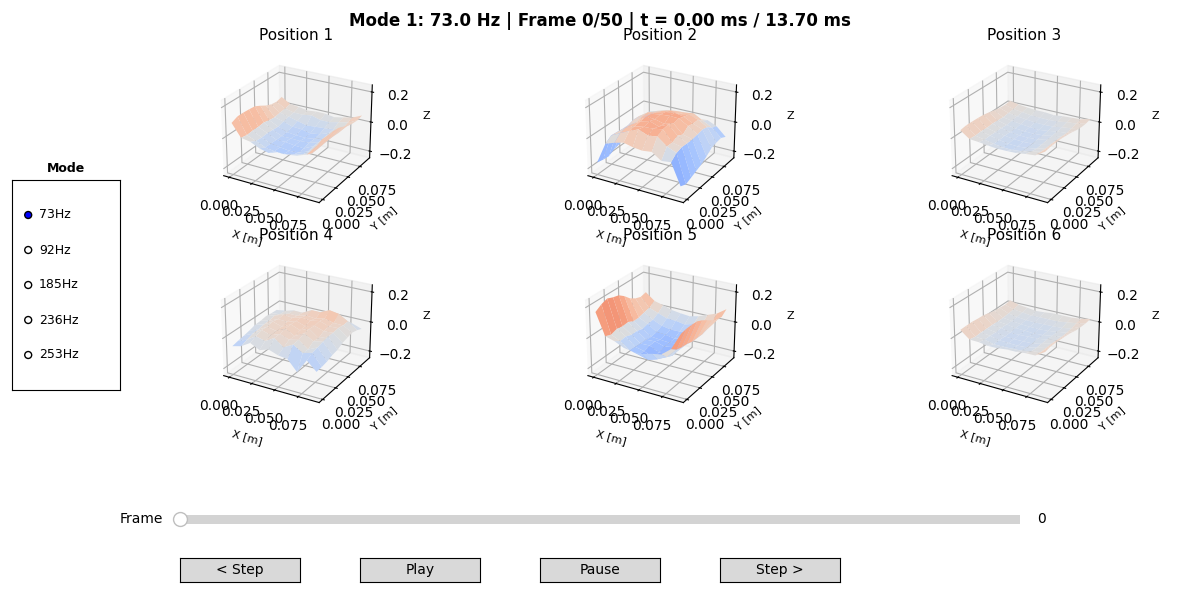

In [43]:
# Animate surface modes across all positions
# Use the slider to move through time, radio buttons to select mode
# Play/Pause buttons control automatic animation, Step buttons for single frames
fig = animate_surface_modes(data, n_frames=50)
plt.show()

In [44]:
for mode_idx in range(5):
    save_surface_animation(data, mode_idx, save_path=f'../results/modes/mode_{mode_idx}.gif')

Saving animation for Mode 1 (73.0 Hz) to ../results/modes/mode_0.gif...
Animation saved to ../results/modes/mode_0.gif
Saving animation for Mode 2 (92.3 Hz) to ../results/modes/mode_1.gif...
Animation saved to ../results/modes/mode_1.gif
Saving animation for Mode 3 (185.8 Hz) to ../results/modes/mode_2.gif...
Animation saved to ../results/modes/mode_2.gif
Saving animation for Mode 4 (236.2 Hz) to ../results/modes/mode_3.gif...
Animation saved to ../results/modes/mode_3.gif
Saving animation for Mode 5 (253.0 Hz) to ../results/modes/mode_4.gif...
Animation saved to ../results/modes/mode_4.gif


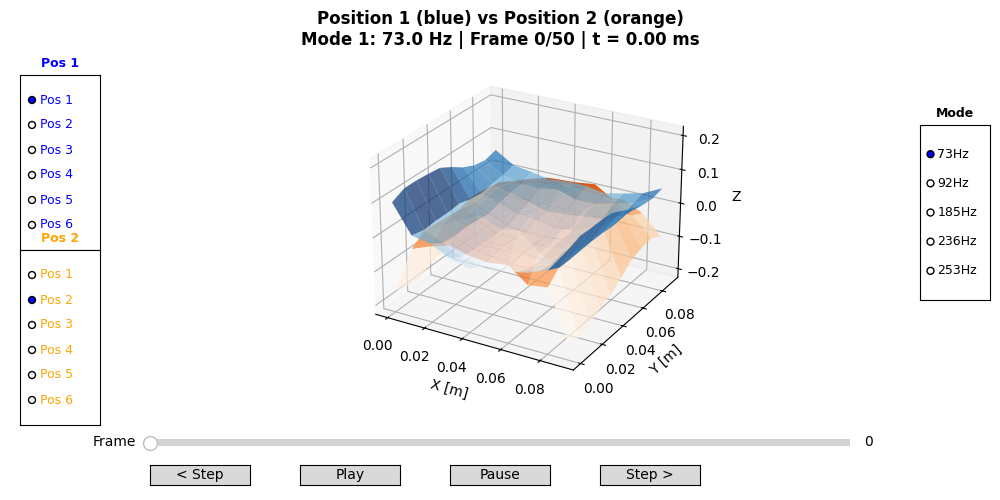

In [45]:
fig = compare_positions(data)
plt.show()

# 6. PCA

In [46]:
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [47]:
def compute_pca(data, max_n_components, x_key, y_key, fft_mode='both', return_x=False):
    """Compute PCA on FFT data from all experiments.

    Args:
        data: dict of experiment data
        max_n_components: max number of PCA components
        x_key: key for FFT values in data (e.g., 'synced_fft_vals')
        y_key: key for labels in data (e.g., 'position')
        fft_mode: 'both' (magnitude + angle), 'magnitude', or 'angle'

    Returns:
        X_pca: PCA-transformed features, shape (n_samples, n_components)
        y: labels array, shape (n_samples,)
        var_exp: explained variance ratio per component
    """
    assert fft_mode in ['both', 'magnitude', 'angle']

    feature_vectors = []
    labels = []

    for name, d in data.items():
        fft_vals = d[x_key]  # shape: (n_lasers, n_modes, n_coords)
        features = fft_vals.flatten()

        # Convert complex FFT to real features based on mode
        if 'fft' in x_key and 'gradients' not in x_key:
            if fft_mode == 'magnitude':
                features = np.abs(fft_vals).flatten()
            elif fft_mode == 'angle':
                features = np.angle(fft_vals).flatten()
            else:  # 'both'
                mag = np.abs(fft_vals).flatten()
                ang = np.angle(fft_vals).flatten()
                features = np.concatenate([mag, ang])

        feature_vectors.append(features)
        labels.append(d[y_key])

    # Stack into matrix
    X = np.vstack(feature_vectors)
    y = np.array(labels)

    # Normalize using StandardScaler
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X)

    # PCA
    n_components = min(max_n_components, X.shape[0])
    pca = PCA(n_components=n_components, random_state=RANDOM_SEED)
    X_pca = pca.fit_transform(X_normalized)

    if return_x: return X_pca, y, pca.explained_variance_ratio_, X
    return X_pca, y, pca.explained_variance_ratio_

In [48]:
def compute_pairwise_distance(X_pca, y):
    """Compute pairwise Euclidean distance matrix and duplicate position accuracy score.

    Args:
        X_pca: array of shape (n_samples, n_features)
        y: array of position labels, shape (n_samples,)

    Returns:
        distances: pairwise distance matrix of shape (n_samples, n_samples)
        duplicate_score: fraction of duplicate pairs where the closest sample has the same position
    """
    distances = cdist(X_pca, X_pca, metric='euclidean')

    # Find duplicate positions (positions that appear more than once)
    unique_positions, counts = np.unique(y, return_counts=True)
    duplicate_positions = unique_positions[counts > 1]

    if len(duplicate_positions) == 0:
        return distances, None  # No duplicates to compare

    # Create a mask for samples with duplicate positions
    duplicate_mask = np.isin(y, duplicate_positions)
    duplicate_indices = np.where(duplicate_mask)[0]

    # Set diagonal to infinity to exclude self-comparisons
    distances_copy = distances.copy()
    np.fill_diagonal(distances_copy, np.inf)

    # For each duplicate sample, find the closest sample
    closest_indices = np.argmin(distances_copy[duplicate_indices], axis=1)

    # Check if the closest samples have the same position
    y_duplicates = y[duplicate_indices]
    y_closest = y[closest_indices]
    correct_matches = np.sum(y_duplicates == y_closest)

    total_duplicate_pairs = len(duplicate_indices)
    duplicate_score = correct_matches / total_duplicate_pairs if total_duplicate_pairs > 0 else 0.0

    return distances, duplicate_score

In [49]:
def plot_pca(X_pca, y, var_exp, title="", plot_2d=True, plot_3d=True):
    """Visualize PCA results in 2D and/or 3D with labeled scatter plots.

    Args:
        X_pca: PCA-transformed features, shape (n_samples, n_components)
        y: position labels, shape (n_samples,)
        var_exp: explained variance ratio per component
        plot_2d: if True, create 2D plot (PC1 vs PC2)
        plot_3d: if True, create 3D plot (PC1 vs PC2 vs PC3)

    Returns:
        fig: matplotlib figure object
    """
    # Determine subplot layout
    n_plots = int(plot_2d) + int(plot_3d)
    if n_plots == 0:
        raise ValueError("At least one of plot_2d or plot_3d must be True")

    # Create figure
    fig = plt.figure(figsize=(4.5 * n_plots, 4))
    plot_idx = 1

    # Get unique positions and assign colors
    unique_positions = np.unique(y)
    colors = [POSITION_COLORS.get(pos, f'C{i}') for i, pos in enumerate(unique_positions)]

    # 2D plot
    if plot_2d:
        ax = fig.add_subplot(1, n_plots, plot_idx)

        for pos, color in zip(unique_positions, colors):
            mask = y == pos
            ax.scatter(X_pca[mask, 0], X_pca[mask, 1],
                      c=color, s=200, alpha=0.7,
                      edgecolor='black', linewidth=1.5,
                      label=f'Pos {pos}')

            # Add position labels on top of each point
            for x, y_val in zip(X_pca[mask, 0], X_pca[mask, 1]):
                ax.text(x, y_val, str(pos),
                       ha='center', va='center',
                       fontsize=10, fontweight='bold', color='white')

        ax.set_xlabel(f'PC1 ({var_exp[0]*100:.1f}% variance)', fontsize=11)
        ax.set_ylabel(f'PC2 ({var_exp[1]*100:.1f}% variance)', fontsize=11)
        ax.set_title('PCA Projection (2D)', fontsize=13, fontweight='bold')
        ax.grid(True, alpha=0.3)

        plot_idx += 1

    # 3D plot
    if plot_3d:
        from mpl_toolkits.mplot3d import proj3d

        ax = fig.add_subplot(1, n_plots, plot_idx, projection='3d')

        for pos, color in zip(unique_positions, colors):
            mask = y == pos
            ax.scatter(X_pca[mask, 0], X_pca[mask, 1], X_pca[mask, 2],
                      c=color, s=200, alpha=0.7,
                      edgecolor='black', linewidth=1.5,
                      label=f'Pos {pos}', depthshade=False)

        # Add all labels after scatter plots to ensure they render on top
        for i in range(len(y)):
            ax.text(X_pca[i, 0], X_pca[i, 1], X_pca[i, 2], str(y[i]),
                   ha='center', va='center',
                   fontsize=10, fontweight='bold', color='white',
                   zorder=100)

        ax.set_xlabel(f'PC1 ({var_exp[0]*100:.1f}%)', fontsize=10)
        ax.set_ylabel(f'PC2 ({var_exp[1]*100:.1f}%)', fontsize=10)
        ax.set_zlabel(f'PC3 ({var_exp[2]*100:.1f}%)', fontsize=10)
        ax.set_title('PCA Projection (3D)', fontsize=13, fontweight='bold')

    if title: fig.suptitle(title)
    plt.tight_layout()
    return fig

In [50]:
def plot_explained_variance(var_exp, title='PCA Explained Variance'):
    """Plot explained variance ratio per component as bar chart with cumulative line.

    Args:
        var_exp: array of explained variance ratios per component
        title: plot title

    Returns:
        fig: matplotlib figure object
    """
    n_components = len(var_exp)
    x = np.arange(1, n_components + 1)
    cumulative = np.cumsum(var_exp)

    fig, ax = plt.subplots(figsize=(8, 5))

    # Bar chart for individual variance
    bars = ax.bar(x, var_exp * 100, color='steelblue', alpha=0.7,
                  edgecolor='black', linewidth=1, label='Individual')

    # Add percentage labels on bars
    for bar, var in zip(bars, var_exp):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 1,
                f'{var*100:.1f}%', ha='center', va='bottom', fontsize=9)

    # Line plot for cumulative variance
    ax.plot(x, cumulative * 100, 'o-', color='darkorange', linewidth=2,
            markersize=8, label='Cumulative')

    # Add cumulative percentage labels
    for xi, cum in zip(x, cumulative):
        ax.text(xi + 0.1, cum * 100 + 2, f'{cum*100:.1f}%',
                ha='left', va='bottom', fontsize=9, color='darkorange')

    ax.set_xlabel('Principal Component', fontsize=11)
    ax.set_ylabel('Explained Variance (%)', fontsize=11)
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([f'PC{i}' for i in x])
    ax.set_ylim(0, 110)
    ax.legend(loc='center right')
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    return fig

In [51]:
list(d.keys())

['object',
 'position',
 'duplicate_idx',
 'fs',
 'path',
 'shifts_raw',
 'time',
 'shifts',
 'fft_vals',
 'freqs',
 '_mode_freqs_idx',
 '_mode_freqs',
 '_mode_fft_vals',
 'mode_freqs',
 'mode_freqs_idx',
 'mode_fft_vals',
 'synced_fft_vals',
 'synced_mode_fft_vals',
 'synced_fft_gradients',
 'synced_mode_fft_gradients']

In [52]:
x_key='synced_fft_vals'

X_pca, y, var_exp = compute_pca(
    data, max_n_components=8,
    x_key=x_key, y_key='position', fft_mode='magnitude'
    )
dist_matrix, duplicate_score = compute_pairwise_distance(X_pca, y)

var_exp

array([2.65269854e-01, 1.83287515e-01, 1.65469400e-01, 1.37476086e-01,
       1.20591768e-01, 7.05546420e-02, 5.73507347e-02, 1.12068870e-29])

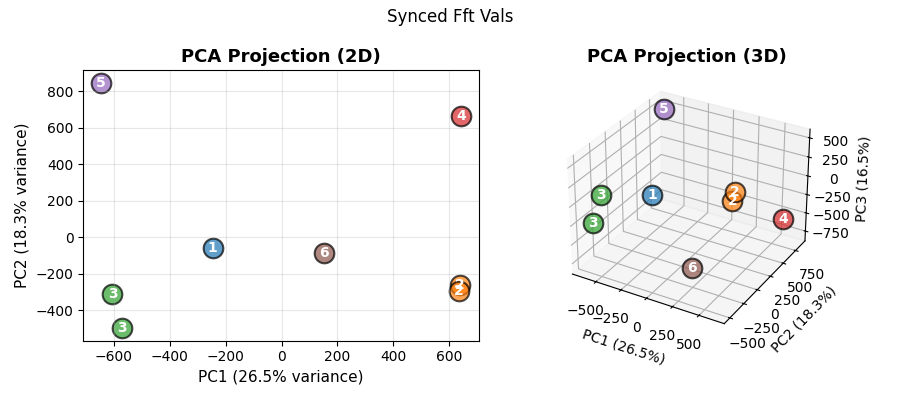

In [53]:
# Plot both 2D and 3D
fig = plot_pca(X_pca, y, var_exp, title=x_key.replace('_', ' ').title())
plt.show()

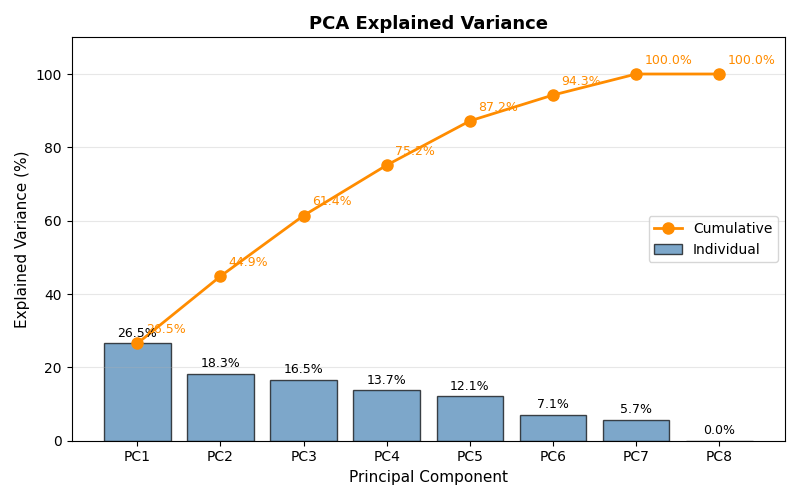

In [54]:
fig = plot_explained_variance(var_exp)
plt.show()

In [55]:
list(d.keys())

['object',
 'position',
 'duplicate_idx',
 'fs',
 'path',
 'shifts_raw',
 'time',
 'shifts',
 'fft_vals',
 'freqs',
 '_mode_freqs_idx',
 '_mode_freqs',
 '_mode_fft_vals',
 'mode_freqs',
 'mode_freqs_idx',
 'mode_fft_vals',
 'synced_fft_vals',
 'synced_mode_fft_vals',
 'synced_fft_gradients',
 'synced_mode_fft_gradients']

In [56]:
x_keys = ['shifts_raw', 'shifts', 'fft_vals', 'synced_fft_vals', 'synced_mode_fft_vals', 'synced_mode_fft_gradients']
labels = ['1. Raw Shifts', '2. Cleaned Shifts', '3. FFT Magnitude', '4. Synced FFT Magnitude', '5. Mode Synced FFT Magnitude', '6. Mode Synced Gradient']

1. Raw Shifts (6000000 dims)
2. Cleaned Shifts (6000000 dims)
3. FFT Magnitude (1140200 dims)
4. Synced FFT Magnitude (1140200 dims)
5. Mode Synced FFT Magnitude (1000 dims)
6. Mode Synced Gradient (1000 dims)


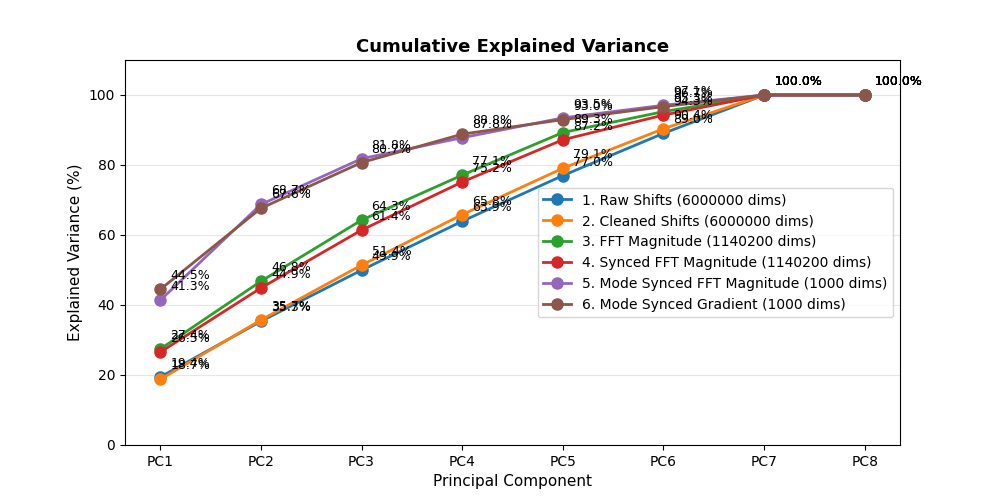

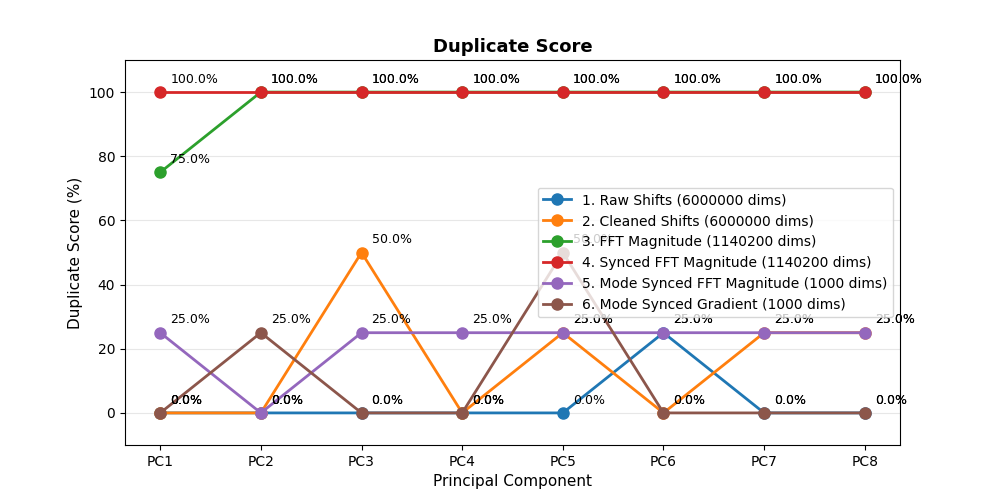

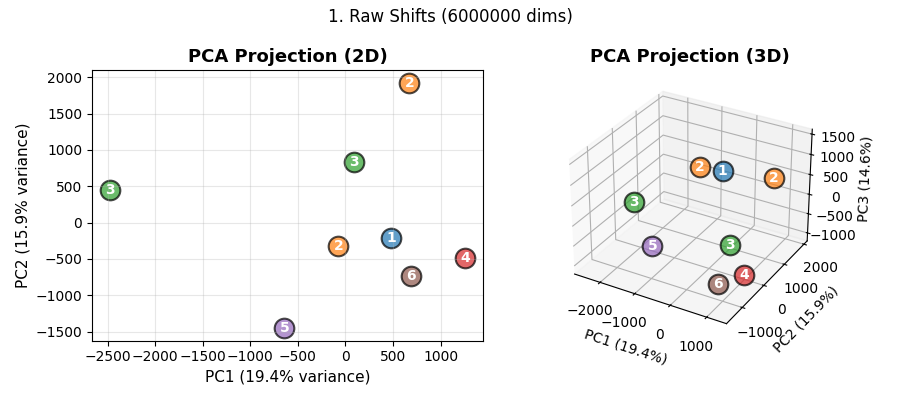

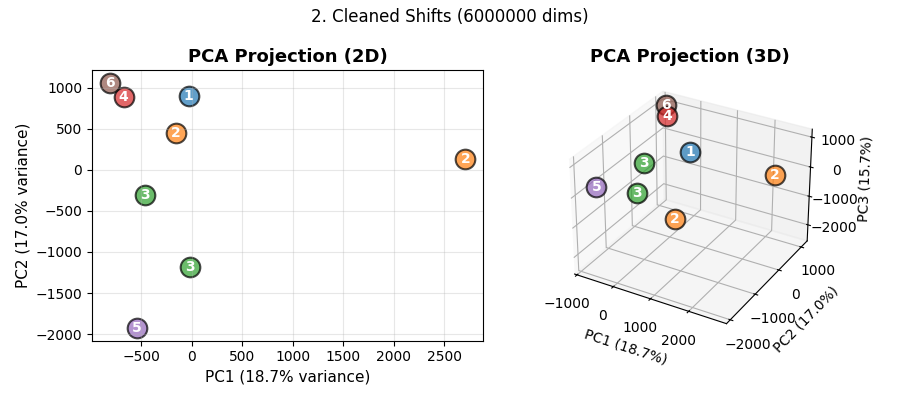

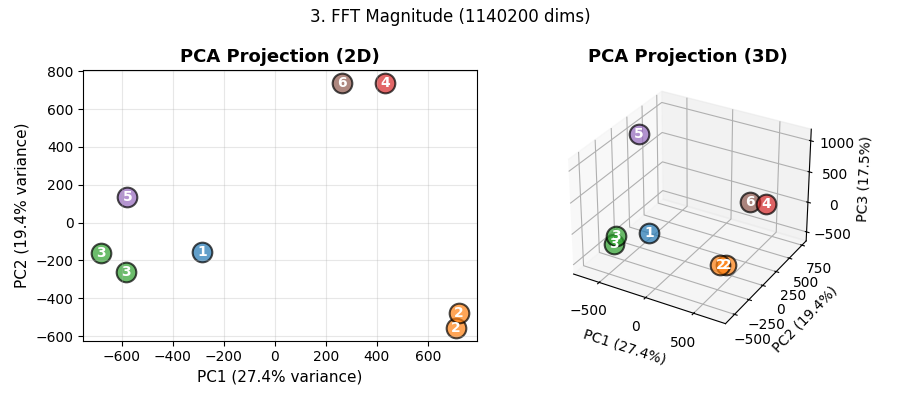

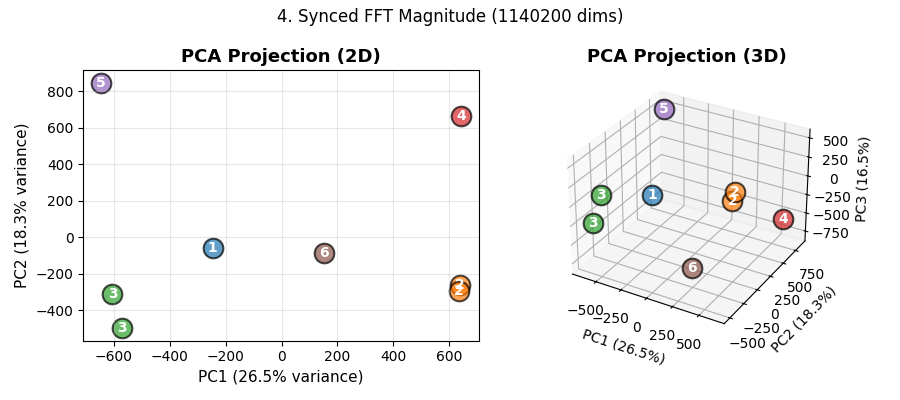

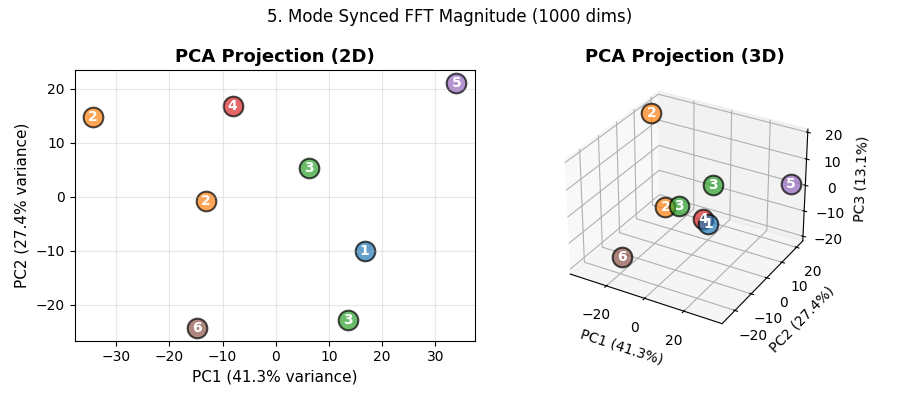

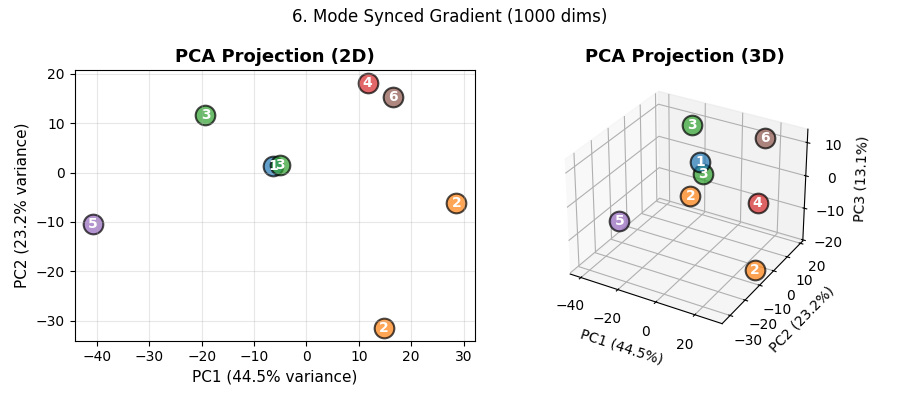

In [57]:
max_n_components = 8
fig, ax = plt.subplots(figsize=(10, 5))
fi2, ax2 = plt.subplots(figsize=(10, 5))

for x_key, _label in zip(x_keys, labels):
        X_pca, y, var_exp, X = compute_pca(data, max_n_components=max_n_components, x_key=x_key, y_key='position', fft_mode='magnitude', return_x=True)

        n_dims = X.shape[1] # todo: shouldn't n_dims be different for mode vs all frequencies?
        label = _label + f' ({n_dims} dims)'
        print(label)

        n_components = len(var_exp)
        x = np.arange(1, n_components + 1)
        cumulative = np.cumsum(var_exp)

        # plot cumulative variance
        ax.plot(x, cumulative * 100, 'o-',linewidth=2, markersize=8, label=label)
        for xi, cum in zip(x, cumulative):
                ax.text(xi + 0.1, cum * 100 + 2, f'{cum*100:.1f}%', ha='left', va='bottom', fontsize=9)

        # plot duplicate scores
        duplicate_scores = np.array([compute_pairwise_distance(X_pca[:, :pca_dim+1], y)[1] for pca_dim in range(max_n_components)])
        ax2.plot(x, duplicate_scores*100, 'o-',linewidth=2, markersize=8, label=label)
        for xi, score in zip(x, duplicate_scores):
                ax2.text(xi + 0.1, score * 100 + 2, f'{score*100:.1f}%', ha='left', va='bottom', fontsize=9)

        # plot 2d/3d PCA
        fig3 = plot_pca(X_pca, y, var_exp, title=label)

ax.set_xlabel('Principal Component', fontsize=11)
ax.set_ylabel('Explained Variance (%)', fontsize=11)
ax.set_title('Cumulative Explained Variance', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f'PC{i}' for i in x])
ax.set_ylim(0, 110)
ax.legend(loc='center right')
ax.grid(True, alpha=0.3, axis='y')


ax2.set_xlabel('Principal Component', fontsize=11)
ax2.set_ylabel('Duplicate Score (%)', fontsize=11)
ax2.set_title('Duplicate Score', fontsize=13, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels([f'PC{i}' for i in x])
ax2.set_ylim(-10, 110)
ax2.legend(loc='center right')
ax2.grid(True, alpha=0.3, axis='y')


In [58]:
import pandas as pd

In [59]:
results = []


x_keys = ['shifts_raw', 'shifts', 'fft_vals', 'synced_fft_vals', 'mode_fft_vals', 'synced_mode_fft_vals', 'synced_mode_fft_gradients', 'synced_fft_gradients']

max_n_components = 8
for x_key in x_keys:
    X_pca, y, var_exp, X = compute_pca(data, max_n_components=max_n_components, x_key=x_key, y_key='position', fft_mode='magnitude', return_x=True)

    n_components = len(var_exp)
    x = np.arange(1, n_components + 1)
    cumulative_var_exp = np.cumsum(var_exp)

    n_dims = X.shape[1]
    synced = 'synced' in x_key
    n_modes = (d[x_key].shape[0] if 'gradients' in x_key else d[x_key].shape[1]) if 'mode' in x_key else -1
    signal = x_key.replace('synced_', '').replace('mode_', '').replace('fft_gradients', 'gradients')

    for pca_dim in range(max_n_components):
        _, duplicate_score = compute_pairwise_distance(X_pca[:, :pca_dim+1], y)
        results.append({
            'signal': signal,
            'pca_dim': pca_dim,
            'n_modes': n_modes,
            'synced': synced,
            'n_dims': n_dims,
            'cum_var_exp': cumulative_var_exp[pca_dim],
            'duplicate_score': duplicate_score,
        })

In [60]:
df = pd.DataFrame(results)
df.head(50)

signal  pca_dim  n_modes  synced   n_dims  cum_var_exp  \
0   shifts_raw        0       -1   False  6000000     0.194276   
1   shifts_raw        1       -1   False  6000000     0.353425   
2   shifts_raw        2       -1   False  6000000     0.499477   
3   shifts_raw        3       -1   False  6000000     0.639295   
4   shifts_raw        4       -1   False  6000000     0.769780   
5   shifts_raw        5       -1   False  6000000     0.890420   
6   shifts_raw        6       -1   False  6000000     1.000000   
7   shifts_raw        7       -1   False  6000000     1.000000   
8       shifts        0       -1   False  6000000     0.187303   
9       shifts        1       -1   False  6000000     0.357147   
10      shifts        2       -1   False  6000000     0.513941   
11      shifts        3       -1   False  6000000     0.658228   
12      shifts        4       -1   False  6000000     0.790740   
13      shifts        5       -1   False  6000000     0.903641   
14      shifts        6       -1   False  6000000     1.000000   
15      shifts        7       -1   False  6000000     1.000000   
16    fft_vals        0       -1   False  1140200     0.274052   
17    fft_vals        1       -1   False  1140200     0.467766   
18    fft_vals        2       -1   False  1140200     0.642513   
19    fft_vals        3       -1   False  1140200     0.771097   
20    fft_vals        4       -1   False  1140200     0.892850   
21    fft_vals        5       -1   False  1140200     0.952505   
22    fft_vals        6       -1   False  1140200     1.000000   
23    fft_vals        7       -1   False  1140200     1.000000   
24    fft_vals        0       -1    True  1140200     0.265270   
25    fft_vals        1       -1    True  1140200     0.448557   
26    fft_vals        2       -1    True  1140200     0.614027   
27    fft_vals        3       -1    True  1140200     0.751503   
28    fft_vals        4       -1    True  1140200     0.872095   
29    fft_vals        5       -1    True  1140200     0.942649   
30    fft_vals        6       -1    True  1140200     1.000000   
31    fft_vals        7       -1    True  1140200     1.000000   
32    fft_vals        0        5   False     1000     0.474442   
33    fft_vals        1        5   False     1000     0.660359   
34    fft_vals        2        5   False     1000     0.822375   
35    fft_vals        3        5   False     1000     0.891624   
36    fft_vals        4        5   False     1000     0.933753   
37    fft_vals        5        5   False     1000     0.969580   
38    fft_vals        6        5   False     1000     1.000000   
39    fft_vals        7        5   False     1000     1.000000   
40    fft_vals        0        5    True     1000     0.413421   
41    fft_vals        1        5    True     1000     0.687267   
42    fft_vals        2        5    True     1000     0.817914   
43    fft_vals        3        5    True     1000     0.877992   
44    fft_vals        4        5    True     1000     0.934586   
45    fft_vals        5        5    True     1000     0.970728   
46    fft_vals        6        5    True     1000     1.000000   
47    fft_vals        7        5    True     1000     1.000000   
48   gradients        0        5    True     1000     0.444548   
49   gradients        1        5    True     1000     0.676312   

    duplicate_score  
0              0.00  
1              0.00  
2              0.00  
3              0.00  
4              0.00  
5              0.25  
6              0.00  
7              0.00  
8              0.00  
9              0.00  
10             0.50  
11             0.00  
12             0.25  
13             0.00  
14             0.25  
15             0.25  
16             0.75  
17             1.00  
18             1.00  
19             1.00  
20             1.00  
21             1.00  
22             1.00  
23             1.00  
24             1.00  
25             1.00  
26             1.00  
27             1.00  
28 

# 7. Correlation

The complex FFT value at one laser point, at one mode frequency, in one direction (x or y)

The phase synchronization (sync_phases) aligns all phases relative to laser 0's x-component, so phase differences between positions are meaningful.

The normalized complex inner product: corr(pos_i, pos_j) = ⟨v_i, v_j⟩ / (‖v_i‖ · ‖v_j‖). This measures how similar the entire vibration signature is between two positions—considering all 100 laser points, all 5 modes, both x/y directions, and both amplitude and phase.

1. Magnitude ≈ 1.0: The two positions have very similar vibration patterns
2. Magnitude ≈ 0: The patterns are uncorrelated (orthogonal in the 1000-D space)
3. Phase ≈ 0: The patterns are in-phase (peaks align)
4. Phase ≈ ±π: The patterns are anti-correlated (one's peaks are the other's troughs)

In [61]:
def compute_complex_correlation(data, fft_key='synced_mode_fft_vals'):
    """Compute pairwise complex correlation between positions.

    Args:
        data: dict of experiment data
        fft_key: key for FFT values to use (default: 'synced_mode_fft_vals')

    Returns:
        corr_matrix: complex correlation matrix of shape (n_positions, n_positions)
        positions: list of position indices
    """
    positions = sorted(set(d['position'] for d in data.values() if d['duplicate_idx'] == 1))
    n_pos = len(positions)

    # Extract flattened complex vectors for each position
    vectors = {}
    for name, d in data.items():
        if d['duplicate_idx'] != 1:
            continue
        # Flatten: (100, 5, 2) -> (1000,) complex vector
        vectors[d['position']] = d[fft_key].flatten()

    # Compute correlation matrix
    corr_matrix = np.zeros((n_pos, n_pos), dtype=complex)
    for i, pos_i in enumerate(positions):
        for j, pos_j in enumerate(positions):
            v_i = vectors[pos_i]
            v_j = vectors[pos_j]
            # Normalized complex correlation (inner product / norms)
            corr = np.vdot(v_i, v_j) / (np.linalg.norm(v_i) * np.linalg.norm(v_j))
            corr_matrix[i, j] = corr

    return corr_matrix, positions


def compute_complex_correlation_per_mode(data, fft_key='synced_mode_fft_vals'):
    """Compute pairwise complex correlation between positions for each mode frequency separately.

    Args:
        data: dict of experiment data
        fft_key: key for FFT values to use (default: 'synced_mode_fft_vals')

    Returns:
        corr_matrices: dict mapping mode_idx -> complex correlation matrix of shape (n_positions, n_positions)
        positions: list of position indices
        mode_freqs: array of mode frequencies
    """
    positions = sorted(set(d['position'] for d in data.values() if d['duplicate_idx'] == 1))
    n_pos = len(positions)

    # Get mode frequencies from first valid entry
    d0 = next(d for d in data.values() if d['duplicate_idx'] == 1)
    mode_freqs = d0['mode_freqs']
    n_modes = len(mode_freqs)

    # Determine data shape based on key type
    is_gradients = 'gradients' in fft_key

    # Extract per-mode complex vectors for each position
    # synced_mode_fft_vals shape: (100, 5, 2) -> 100 lasers, 5 modes, 2 directions (x,y)
    # synced_mode_fft_gradients shape: (5, 2, 10, 10) -> 5 modes, 2 gradient dirs, 10x10 grid
    vectors_per_mode = {mode_idx: {} for mode_idx in range(n_modes)}

    for name, d in data.items():
        if d['duplicate_idx'] != 1:
            continue
        pos = d['position']
        fft_data = d[fft_key]

        for mode_idx in range(n_modes):
            if is_gradients:
                # gradients shape: (n_modes, 2, 10, 10) -> extract mode_idx and flatten
                vec = fft_data[mode_idx].flatten()  # (2, 10, 10) -> (200,)
            else:
                # fft_vals shape: (100, n_modes, 2) -> extract mode_idx and flatten
                vec = fft_data[:, mode_idx, :].flatten()  # (100, 2) -> (200,)
            vectors_per_mode[mode_idx][pos] = vec

    # Compute correlation matrix for each mode
    corr_matrices = {}
    for mode_idx in range(n_modes):
        corr_matrix = np.zeros((n_pos, n_pos), dtype=complex)
        vectors = vectors_per_mode[mode_idx]

        for i, pos_i in enumerate(positions):
            for j, pos_j in enumerate(positions):
                v_i = vectors[pos_i]
                v_j = vectors[pos_j]
                # Normalized complex correlation (inner product / norms)
                corr = np.vdot(v_i, v_j) / (np.linalg.norm(v_i) * np.linalg.norm(v_j))
                corr_matrix[i, j] = corr

        corr_matrices[mode_idx] = corr_matrix

    return corr_matrices, positions, mode_freqs


In [62]:
from matplotlib.patheffects import withStroke

def plot_correlation_matrix(corr_matrix, positions, title="Complex Correlation Between Positions"):
    """Plot magnitude and phase of complex correlation as heatmaps.

    Args:
        corr_matrix: complex correlation matrix of shape (n_positions, n_positions)
        positions: list of position indices
        title: figure title

    Returns:
        fig: matplotlib figure
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Magnitude heatmap
    im1 = axes[0].imshow(np.abs(corr_matrix), cmap='viridis', vmin=0, vmax=1)
    axes[0].set_title('Correlation Magnitude')
    axes[0].set_xticks(range(len(positions)))
    axes[0].set_yticks(range(len(positions)))
    axes[0].set_xticklabels([f'Pos {p}' for p in positions])
    axes[0].set_yticklabels([f'Pos {p}' for p in positions])
    plt.colorbar(im1, ax=axes[0])

    # Add magnitude values as text
    for i in range(len(positions)):
        for j in range(len(positions)):
            val = np.abs(corr_matrix[i, j])
            axes[0].text(j, i, f'{val:.2f}', ha='center', va='center',
                        color='white' if val < 0.5 else 'black', fontsize=9)

    # Phase heatmap
    phase_vals = np.angle(corr_matrix)
    im2 = axes[1].imshow(phase_vals, cmap='twilight', vmin=-np.pi, vmax=np.pi)
    axes[1].set_title('Correlation Phase')
    axes[1].set_xticks(range(len(positions)))
    axes[1].set_yticks(range(len(positions)))
    axes[1].set_xticklabels([f'Pos {p}' for p in positions])
    axes[1].set_yticklabels([f'Pos {p}' for p in positions])
    plt.colorbar(im2, ax=axes[1], label='Phase (rad)')

    # Add phase values as text (use white text with black outline for visibility)
    for i in range(len(positions)):
        for j in range(len(positions)):
            val = phase_vals[i, j]
            # Use white text with black stroke for visibility on twilight colormap
            txt = axes[1].text(j, i, f'{val:.2f}', ha='center', va='center',
                              fontsize=9, fontweight='bold', color='white')
            txt.set_path_effects([withStroke(linewidth=2, foreground='black')])

    fig.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig


def plot_correlation_matrices_per_mode(corr_matrices, positions, mode_freqs, title_prefix="Complex Correlation"):
    """Plot magnitude and phase heatmaps for each mode frequency separately.

    Args:
        corr_matrices: dict mapping mode_idx -> complex correlation matrix
        positions: list of position indices
        mode_freqs: array of mode frequencies
        title_prefix: prefix for figure titles

    Returns:
        figs: list of matplotlib figures (one per mode)
    """
    figs = []
    n_modes = len(corr_matrices)

    for mode_idx in range(n_modes):
        corr_matrix = corr_matrices[mode_idx]
        freq = mode_freqs[mode_idx]
        title = f"{title_prefix} - Mode {mode_idx + 1} ({freq:.1f} Hz)"
        fig = plot_correlation_matrix(corr_matrix, positions, title=title)
        figs.append(fig)

    return figs


Complex Correlation Matrix - All Modes Combined (magnitude):
[[1.    0.709 0.904 0.779 0.929 0.81 ]
 [0.709 1.    0.883 0.693 0.47  0.939]
 [0.904 0.883 1.    0.847 0.706 0.962]
 [0.779 0.693 0.847 1.    0.724 0.882]
 [0.929 0.47  0.706 0.724 1.    0.59 ]
 [0.81  0.939 0.962 0.882 0.59  1.   ]]

Diagonal should be 1.0 (self-correlation)


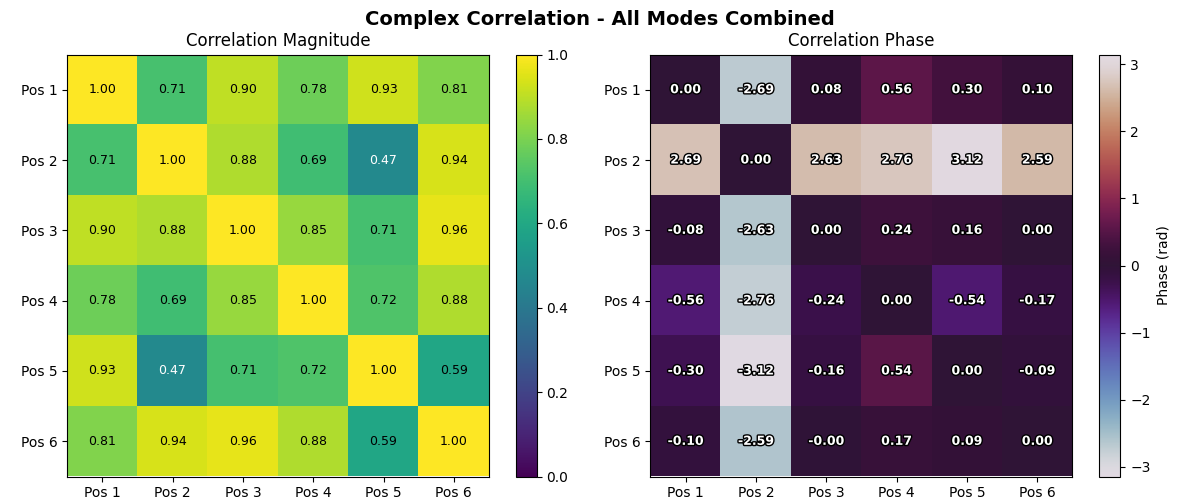


Per-Mode Correlation Analysis

Mode 1 (73.0 Hz) - Correlation Magnitude:
[[1.    0.993 0.996 0.994 0.997 0.996]
 [0.993 1.    0.989 0.996 0.992 0.994]
 [0.996 0.989 1.    0.99  0.998 0.996]
 [0.994 0.996 0.99  1.    0.992 0.995]
 [0.997 0.992 0.998 0.992 1.    0.996]
 [0.996 0.994 0.996 0.995 0.996 1.   ]]

Mode 2 (92.3 Hz) - Correlation Magnitude:
[[1.    0.965 0.959 0.981 0.981 0.982]
 [0.965 1.    0.916 0.961 0.955 0.96 ]
 [0.959 0.916 1.    0.974 0.986 0.983]
 [0.981 0.961 0.974 1.    0.981 0.993]
 [0.981 0.955 0.986 0.981 1.    0.993]
 [0.982 0.96  0.983 0.993 0.993 1.   ]]

Mode 3 (185.8 Hz) - Correlation Magnitude:
[[1.    0.994 0.989 0.984 0.966 0.989]
 [0.994 1.    0.98  0.989 0.956 0.995]
 [0.989 0.98  1.    0.967 0.969 0.976]
 [0.984 0.989 0.967 1.    0.949 0.987]
 [0.966 0.956 0.969 0.949 1.    0.941]
 [0.989 0.995 0.976 0.987 0.941 1.   ]]

Mode 4 (236.2 Hz) - Correlation Magnitude:
[[1.    0.995 0.996 0.991 0.998 0.994]
 [0.995 1.    0.994 0.994 0.995 0.997]
 [0.996 0.99

/var/folders/f6/vzqh7ynx4n3ft_sx36yv3gbm0000gn/T/ipykernel_86841/1317867358.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, 2, figsize=(12, 5))


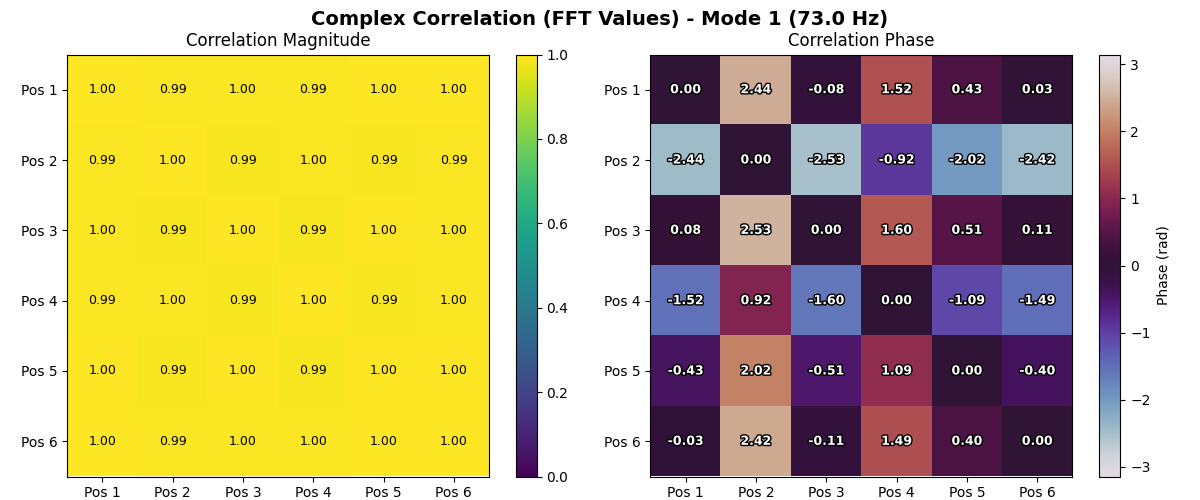

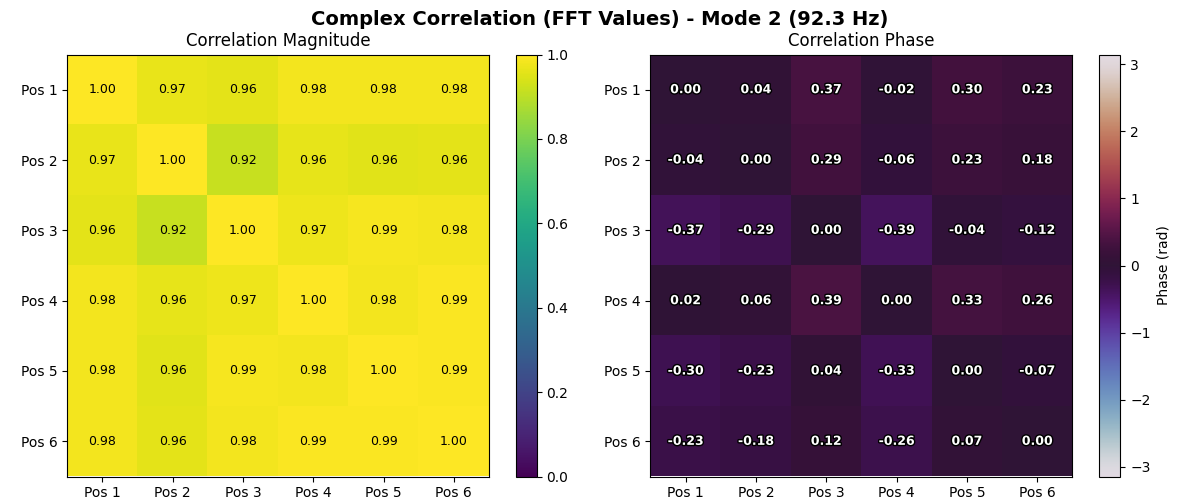

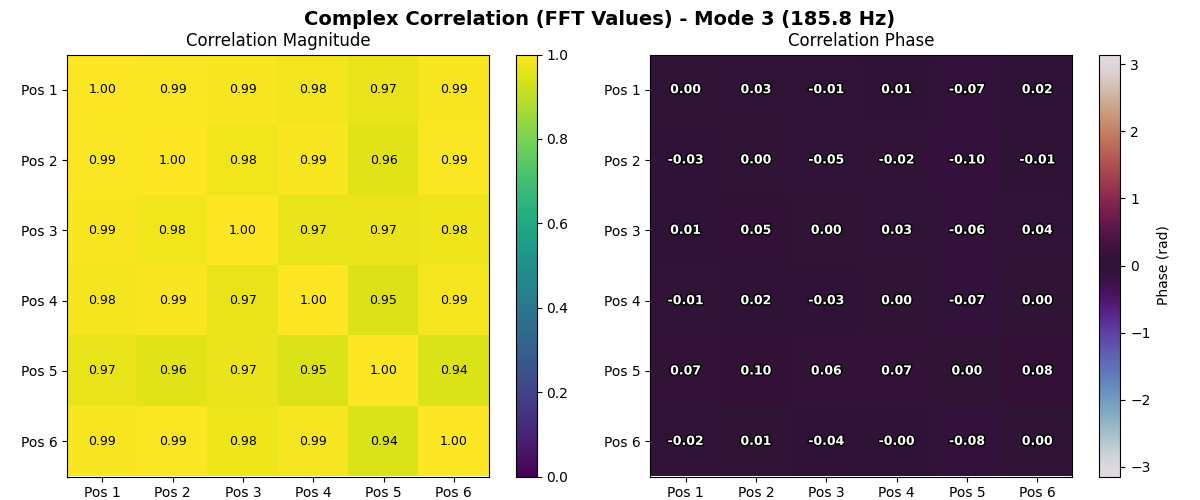

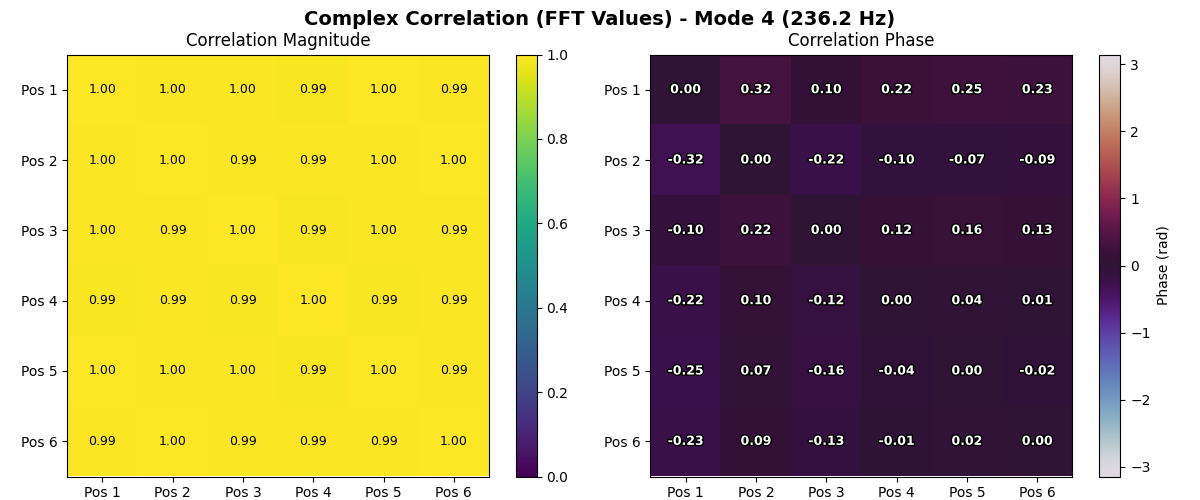

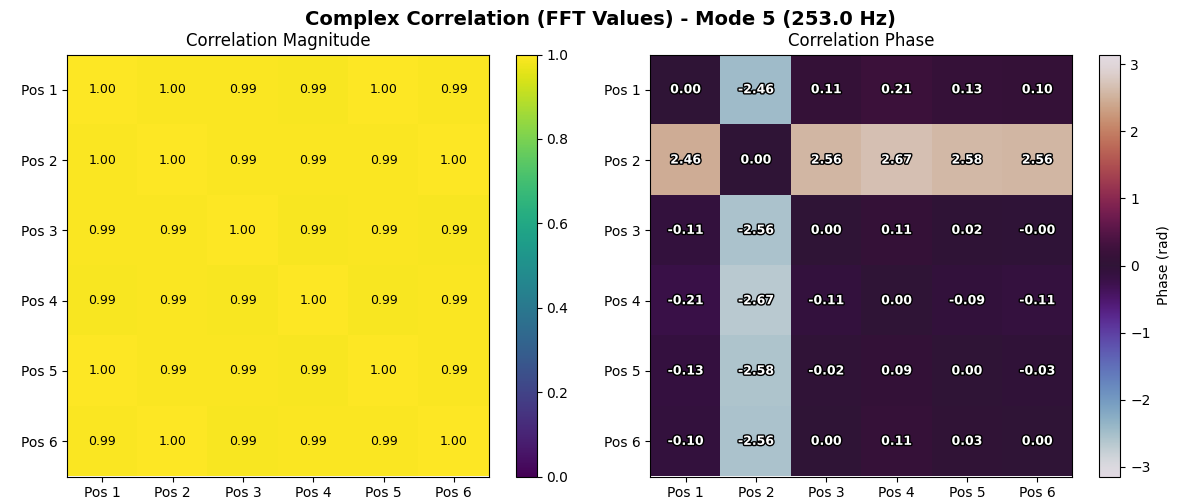

In [63]:
# Compute and visualize complex correlation between positions (aggregated across all modes)
corr_matrix, positions = compute_complex_correlation(data, fft_key='synced_mode_fft_vals')

print("Complex Correlation Matrix - All Modes Combined (magnitude):")
print(np.abs(corr_matrix).round(3))
print("\nDiagonal should be 1.0 (self-correlation)")

fig = plot_correlation_matrix(corr_matrix, positions, title="Complex Correlation - All Modes Combined")
plt.show()

# Compute and visualize complex correlation for EACH mode frequency separately
print("\n" + "="*60)
print("Per-Mode Correlation Analysis")
print("="*60)

corr_matrices_per_mode, positions, mode_freqs = compute_complex_correlation_per_mode(data, fft_key='synced_mode_fft_vals')

for mode_idx, corr_matrix in corr_matrices_per_mode.items():
    freq = mode_freqs[mode_idx]
    print(f"\nMode {mode_idx + 1} ({freq:.1f} Hz) - Correlation Magnitude:")
    print(np.abs(corr_matrix).round(3))

# Plot each mode's correlation separately
figs = plot_correlation_matrices_per_mode(corr_matrices_per_mode, positions, mode_freqs, title_prefix="Complex Correlation (FFT Values)")
# for fig in figs:
#     plt.show()


Complex Correlation Matrix - Gradients, All Modes Combined (magnitude):
[[1.    0.863 0.912 0.716 0.963 0.823]
 [0.863 1.    0.928 0.886 0.74  0.951]
 [0.912 0.928 1.    0.928 0.776 0.969]
 [0.716 0.886 0.928 1.    0.513 0.975]
 [0.963 0.74  0.776 0.513 1.    0.653]
 [0.823 0.951 0.969 0.975 0.653 1.   ]]


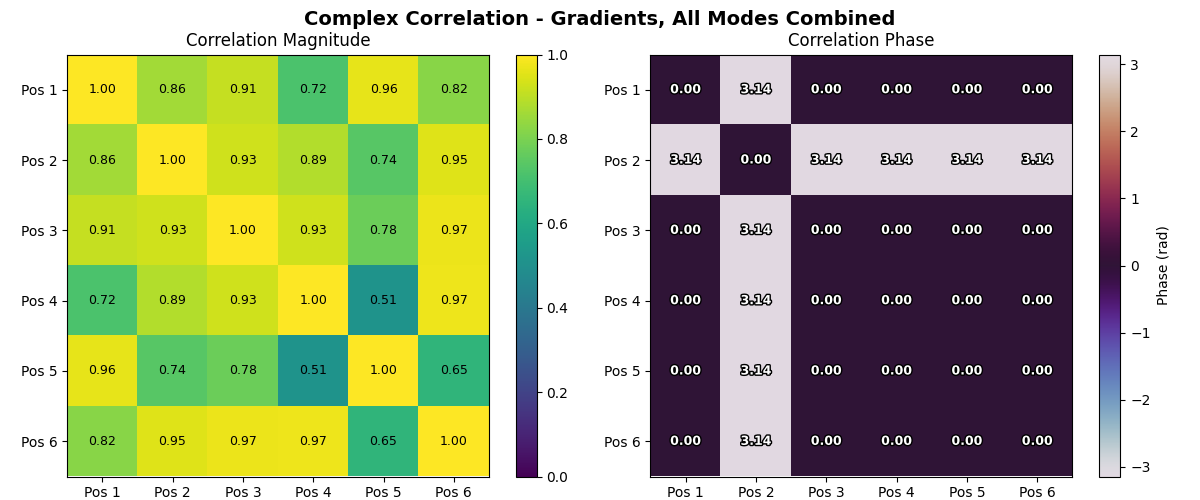


Per-Mode Correlation Analysis (Gradients)

Mode 1 (73.0 Hz) - Gradient Correlation Magnitude:
[[1.    0.994 0.997 0.864 0.997 0.996]
 [0.994 1.    0.996 0.898 0.996 0.997]
 [0.997 0.996 1.    0.882 0.998 0.996]
 [0.864 0.898 0.882 1.    0.879 0.879]
 [0.997 0.996 0.998 0.879 1.    0.997]
 [0.996 0.997 0.996 0.879 0.997 1.   ]]

Mode 2 (92.3 Hz) - Gradient Correlation Magnitude:
[[1.    0.977 0.996 0.988 0.992 0.992]
 [0.977 1.    0.981 0.98  0.985 0.987]
 [0.996 0.981 1.    0.988 0.997 0.995]
 [0.988 0.98  0.988 1.    0.982 0.994]
 [0.992 0.985 0.997 0.982 1.    0.993]
 [0.992 0.987 0.995 0.994 0.993 1.   ]]

Mode 3 (185.8 Hz) - Gradient Correlation Magnitude:
[[1.    0.995 0.989 0.989 0.961 0.992]
 [0.995 1.    0.981 0.993 0.949 0.996]
 [0.989 0.981 1.    0.974 0.965 0.98 ]
 [0.989 0.993 0.974 1.    0.95  0.993]
 [0.961 0.949 0.965 0.95  1.    0.939]
 [0.992 0.996 0.98  0.993 0.939 1.   ]]

Mode 4 (236.2 Hz) - Gradient Correlation Magnitude:
[[1.    0.996 0.996 0.993 0.998 0.995]
 [0

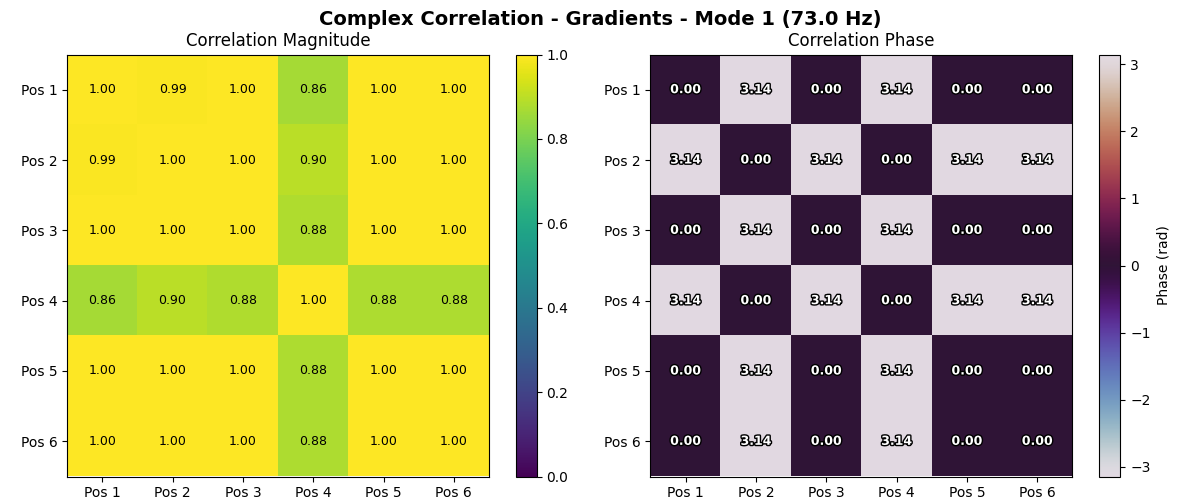

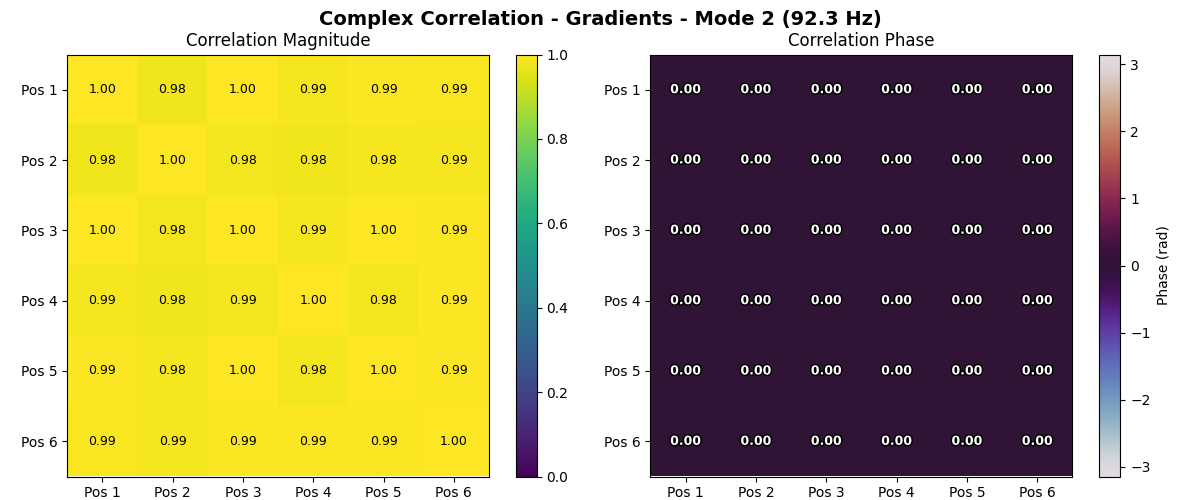

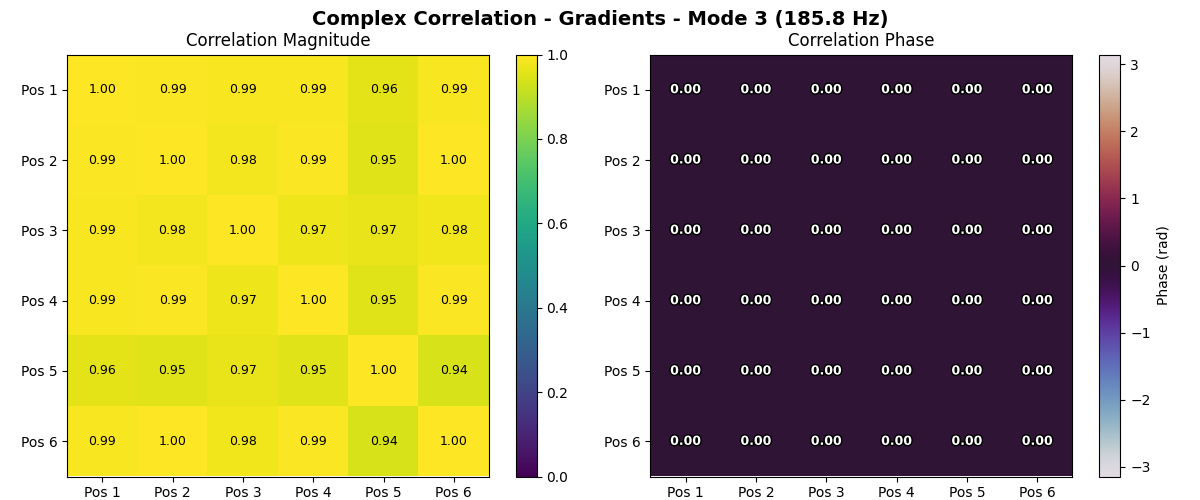

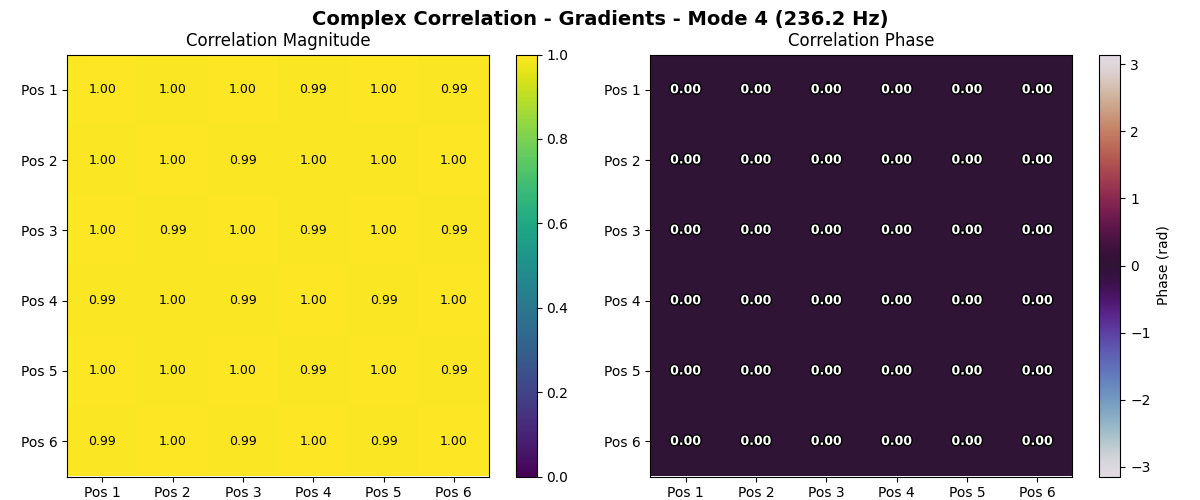

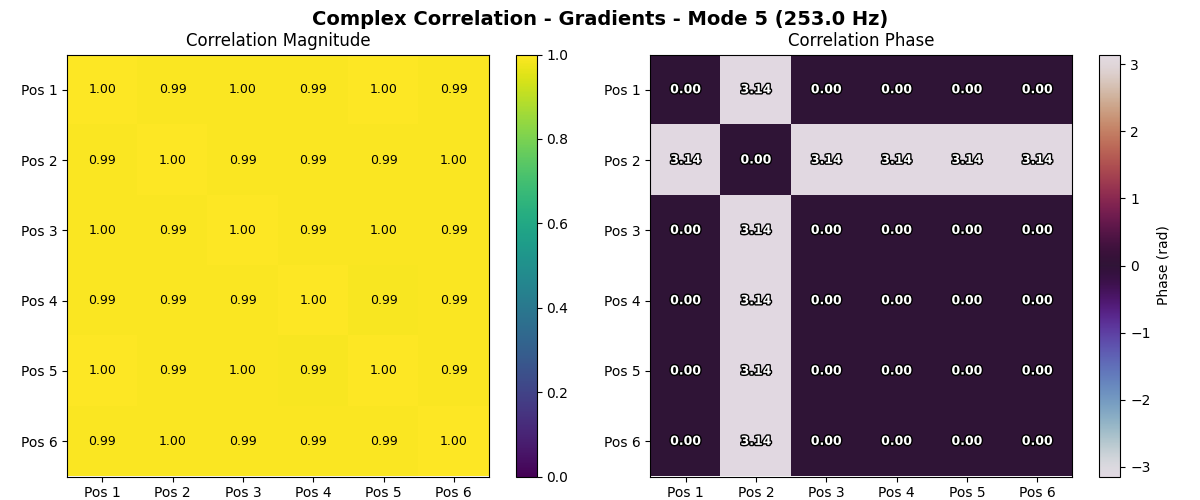

In [64]:
# Compute and visualize complex correlation between positions using gradients (aggregated)
corr_matrix_grad, positions_grad = compute_complex_correlation(data, fft_key='synced_mode_fft_gradients')

print("Complex Correlation Matrix - Gradients, All Modes Combined (magnitude):")
print(np.abs(corr_matrix_grad).round(3))

fig = plot_correlation_matrix(corr_matrix_grad, positions_grad, title="Complex Correlation - Gradients, All Modes Combined")
plt.show()

# Compute and visualize complex correlation for EACH mode frequency separately (gradients)
print("\n" + "="*60)
print("Per-Mode Correlation Analysis (Gradients)")
print("="*60)

corr_matrices_grad_per_mode, positions_grad, mode_freqs = compute_complex_correlation_per_mode(data, fft_key='synced_mode_fft_gradients')

for mode_idx, corr_matrix in corr_matrices_grad_per_mode.items():
    freq = mode_freqs[mode_idx]
    print(f"\nMode {mode_idx + 1} ({freq:.1f} Hz) - Gradient Correlation Magnitude:")
    print(np.abs(corr_matrix).round(3))

# Plot each mode's correlation separately
figs = plot_correlation_matrices_per_mode(corr_matrices_grad_per_mode, positions_grad, mode_freqs, title_prefix="Complex Correlation - Gradients")
# for fig in figs:
#     plt.show()
